In [ ]:
!git checkout https://github.com/mmatteid/Idoven-Data-Scientist.git

## Loading ECG data

electrocardiogram (ECG) is the representation of the electrical signal generated by the heart while beating. The heart is an electrically controlled muscle. The voltage signal occurring due to the electrical pulses that control the heartbeat also reflect how the heart is beating, and thus can reflect relevant information such as cardiac arrhythmias and events. The ECG signal can be challenging because it exhibits considerable variability between subjects, and in long term procedures it is subject to environmental noise, such as movement from the patient (low frequency noise) or electrical noise from nearby electrical devices (50 Hz or 60 Hz). 


This notebook contains my insights and experience on how to work with ecg. Thus, I will demonstrate how to load it, process it, interpret it, analyze it and both time and frequency domain, and use it to train deep learning models.

we will start by downloading the data from the physionet database, viewing it and understanding its format, and then processing it.

In [ ]:
pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#importing necessary packages
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import sklearn
from keras.layers import Conv1D, Dropout, Input, BatchNormalization, Flatten, Dense, Conv3DTranspose, UpSampling3D, Flatten, Reshape, Conv1D, LSTM, ConvLSTM1D
import tensorflow as tf
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
import wfdb
import ast
import pandas as pd
import itertools


In [ ]:
#loading data from compressed file in my drive

!unzip /content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2.zip

Archive:  /content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2.zip
replace ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/RECORDS? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/SHA256SUMS.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#This code was taken from the physionet example. I will use it to loas the data.
#this is the recommended way of loading the data, so I will use this and print some examples to observe the format of the data and annotations

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

#I will work with the data sampled at 100Hz for speed purposes as this is just an exploratory analysis of the dataset.
#I would increase the resolution after identifying relevant features if needed, or to train a neural network.

path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass. Thus lumps smaller arrhythmia subclasses into lasrger categories
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


## Plotting some data examples and visualizing annotations

I will start by plotting the first 10-second signal chunk including all channels, and marking the location of rpeaks


In [ ]:
X.shape

(21801, 1000, 12)

The shape of the singal data shows us we have 21801 recordings, each of 10 seconds samples at 100Hz and with 12 channels per ecg recording. This is takjen using a 12 lead system as displayed below 

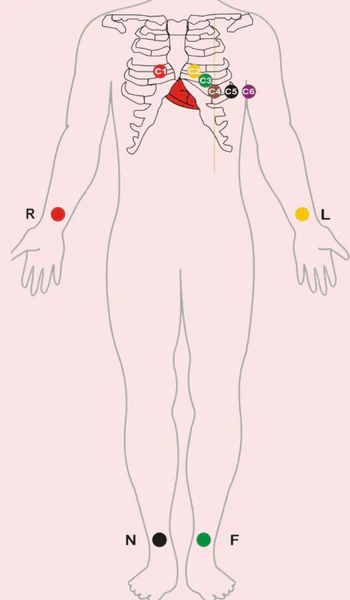

Image taken from (https://www.biometriccables.in/blogs/blog/12-lead-ecg-cable-electrode-placement)

It must be noticed this is a clinical setting and thus not suitable for long-term wearing. Typically we would have less channels (one or two). It will also produce less noisy signals as the wsubject is static for a short period of time. In reality, with wearable devices, ECG can be quite volatile, with low frequency oscillations from the subject's movement and high frequency noise from electrical interference.


I will experiment with this 100Hz data for speed. While in the time domain this frequnecy might be ok, it is important to consider that in the frequnecy domain we will only be able to observe features in the range 0-50Hz as per Nyquist's theorem. In industry, we would trust even less than that range. Usually we consider frequencies up to 1/3 of the sampling frequnecy, and sometimes even less.

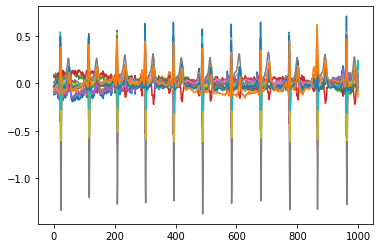

In [ ]:
#creating composite plot of the 12- lead ecg
#channels are plotted in an overlap
for channel in X[0].T:

  plt.plot(channel)

The first things that is obvious in this composite plot is the variability of the ecg signal. Depending on the location of the leads, we will have varying signal amplitude and morphology for the same heartbeat. For example, a channel may depict the QRS peak in an opposite direction to the other channels due to it's position relative to the heart. Similarly, leads can pick up noise differently. For example, a lead closer to the left arm may show low frequency noise if the patient moves the arm on a long-term recording. 


In [ ]:
#let's visualize the annotations of the data to identify important fields
Y

patient_id    age  sex  height  weight  nurse  site      device  \
ecg_id                                                                    
1          15709.0   56.0    1     NaN    63.0    2.0   0.0   CS-12   E   
2          13243.0   19.0    0     NaN    70.0    2.0   0.0   CS-12   E   
3          20372.0   37.0    1     NaN    69.0    2.0   0.0   CS-12   E   
4          17014.0   24.0    0     NaN    82.0    2.0   0.0   CS-12   E   
5          17448.0   19.0    1     NaN    70.0    2.0   0.0   CS-12   E   
...            ...    ...  ...     ...     ...    ...   ...         ...   
21833      17180.0   67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  300.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0   59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0   64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0   68.0    0     NaN     NaN    1.0   2.0  AT-60    3   

             recording_date  \
ecg_id                        
1       1984-11-09 09:17:34   
2       1984-11-14 12:55:37   
3       1984-11-15 12:49:10   
4       1984-11-15 13:44:57   
5       1984-11-17 10:43:15   
...                     ...   
21833   2001-05-31 09:14:35   
21834   2001-06-05 11:33:39   
21835   2001-06-08 10:30:27   
21836   2001-06-09 18:21:49   
21837   2001-06-11 16:43:01   

                                                   report  ... QRS-CLBB  \
ecg_id                                                     ...            
1                  sinusrhythmus periphere niederspannung  ...    False   
2                     sinusbradykardie sonst normales ekg  ...    False   
3                              sinusrhythmus normales ekg  ...    False   
4                              sinusrhythmus normales ekg  ...    False   
5                              sinusrhythmus normales ekg  ...    False   
...                                                   ...  ...      ...   
21833   ventrikulÄre extrasystole(n) sinustachykardie ...  ...    False   
21834   sinusrhythmus lagetyp normal qrs(t) abnorm    ...  ...    False   
21835   sinusrhythmus lagetyp normal t abnorm in anter...  ...    False   
21836   supraventrikulÄre extrasystole(n) sinusrhythmu...  ...    False   
21837   sinusrhythmus p-sinistrocardiale lagetyp norma...  ...    False   

       ST-ELEV-MI ST-DEPR-MI  Q-ISC  Q-ISC-QPeak  Q-ISC-V2V3  Q-ISC-RPeak  \
ecg_id                                                                      
1           False      False  False        False       False        False   
2           False      False  False        False       False        False   
3           False      False  False        False       False        False   
4           False      False  False        False       False        False   
5           False      False  False        False       False        False   
...           ...        ...    ...          ...         ...          ...   
21833       False       True  False        False       False        False   
21834       False      False  False        False       False        False   
21835       False      False  False        False       False        False   
21836       False      False  False        False       False        False   
21837       False      False  False        False       False        False   

        STRAIN MI-ALL diagnostic_superclass  
ecg_id                                       
1        False  False                [NORM]  
2        False  False                [NORM]  
3        False  False                [NORM]  
4        False  False                [NORM]  
5        False  False                [NORM]  
...        ...    ...                   ...  
21833    False   True                [STTC]  
21834    False  False                [NORM]  
21835    False  False                [STTC]  
21836    False  False                [NORM]  
21837    False  False                [NORM]  

[21801 rows x 44 columns]

Some relevant fields that I can identify tha may be important for an initial analysis: 

- The scp codes column informs us about the presence of events and rhythm, for example, if the beat is normal or if there is atrial flutter or fibrillation, which are arrhythmias of medical concern and thusn we would be interested on benchmarking and detecting [Granada, Juan, et al. "Incidence and predictors of atrial flutter in the general population." Journal of the American College of Cardiology 36.7 (2000): 2242-2246.]. 

-  The two infarction stadium columns provide information on the stage of infarction if present, comprehending stages I-II and III-IV respectively [Wagner, Patrick & Strodthoff, Nils & Bousseljot, Ralf-Dieter & Kreiseler, Dieter & Lunze, Fatima & Samek, Wojciech & Schaeffter, Tobias. (2020). PTB-XL, a large publicly available electrocardiography dataset. Scientific Data. 7. 154. 10.1038/s41597-020-0495-6. ]

- The baseline drift column indicates in which leads we have low-frequency noise such as baseline wandering

- the static noise column indicates whether we have high-frequency noise such as electrical noise present.

- The rpeaks are contained in the CSV file. In many cases, analysis of ECG  starts in Rpeaks because they give us a marker for relevant parts of the signal that technicians look at for information. In many cases, algorithms can also get useful information from these benchmark locations. I will get the annotated rpeaks from the csv provided by physionet. In practice, if an algorithm is put out on the field, some sort of peak-deection algorithm such as Hamilton (free to use, standardized and approved by FDA ) can be used for peak detection and preprocessing [Hamilton, Pat. "Open source ECG analysis." Computers in cardiology. IEEE, 2002.]

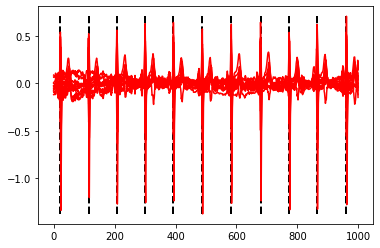

In [ ]:
#loading CSV, it's ordered the same way as the waveforms
annots = pd.read_csv('/content/drive/MyDrive/ptbxl_database.csv')

#plotting signal
for channel in X[0].T:

  plt.plot(channel, c= 'r')

#ploting rpeaks. peaks are identified for the 100hz signal and thus are indexes from 0-1000
#the datframe tells us on whihch sample of the ecg fragment thare is a peak
#transforming text peaks to integers
peaks = [int(peak) for peak in annots['r_peaks'][0].split('[')[-1].split(']')[0].split()]

#plotting peasks as dotted lines
for peakline in peaks:
  plt.vlines(x= peakline, ymin=np.min(X[0].T), ymax = np.max(X[0].T), linestyles='--', lw=2, label='Rpeak')

Rpeaks are provided for each ecg snippet. However, they may be found in slightly different indexes across channels becaause some leads experience delay on the signal depending on where they are placed.

In [ ]:
#if we want to look at individual beats, I would use the rpeak to find said beat and plot the neighborhood around it.
#this is relevant because we sometimes need to obtain features from a smaller region

def plot_ecg(ecg_dictionary, signals, peaks_df, beat_type = 'NORM', sampling_freq = 100, rec = 1, seg_len=100):

  '''
  Function to find and plot a random beat of a specified beat type in an ecg recording from the MIT database

  Args: 
  ecg_dictionary: Dict
    Dicitonary storing beat types

  procedure: string
    Name of the procedure from which we would like to plot. 

  beat_type: String 
    Specifies the beat type we would like to plot, from the annotations in the ecg_dictionary.

  Sampling Freq: Integer
    Deffaults to 100, sampling frequency of database, used to measure the time in the x axis. 

  rpeak: Int
    Deffaults to 1. Indicates the index of the rpeak (out of the rpeaks containing the type of beat specified)
    that we want to plot. 
  
  seg_len: Int
    Defaults to 100 and controls the size of the chunk of ECG we wish to plot, centered around the R-peak specified. 

  
  '''

  #finding random beat of specified type for plotting, and corresponding rpeak.
  #we find if the desired beat type is in the dictionary keys for the ecgs, which meansd the type of beat is present

  indexes_of_interest = [beat_type in ecg_dictionary['scp_codes'][i].keys() for i in ecg_dictionary['scp_codes'].keys()]
 
  #plot the desired recording index out of the recordings with specified arrhythmia
  ecg= signals[indexes_of_interest][rec]
  peaks = [int(peak) for peak in peaks_df['r_peaks'][indexes_of_interest].iloc[rec].split('[')[-1].split(']')[0].split()]
  
  #axis is the same length of the segment selected
  x_axis_complete=np.linspace(0, seg_len/sampling_freq , len(ecg))

  #plotting overall ecg
  plt.figure()
  plt.plot(x_axis_complete, ecg)

  #plotting rpeaks and surrounding area:
  half_segment = seg_len/2

  
  i=1
  for peak in peaks:
    sig_chunk = ecg[int(peak-half_segment) if peak>half_segment else 0: int(peak+half_segment) if int(peak+half_segment)<len(ecg) else -1 ]
    x_axis_chunk = np.linspace(0, seg_len/sampling_freq , len(sig_chunk))
 
    plt.figure()
    plt.title('Peak at sample ' + str(peak))
    plt.plot(x_axis_chunk, sig_chunk)
    plt.xlabel('Time (s)')

    i+=1
  plt.show()
  


---------------- NORM ---------------


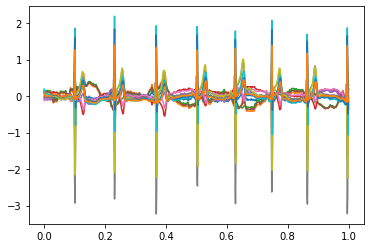

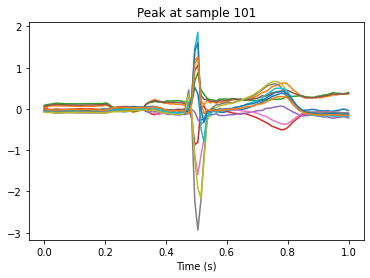

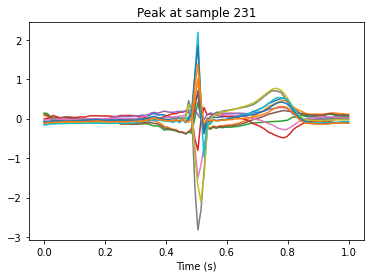

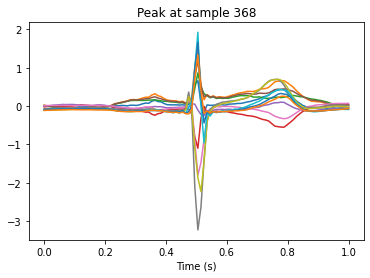

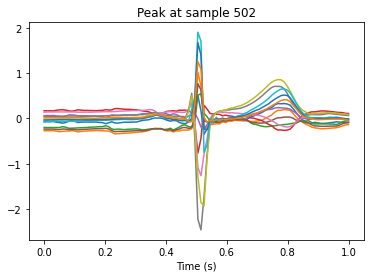

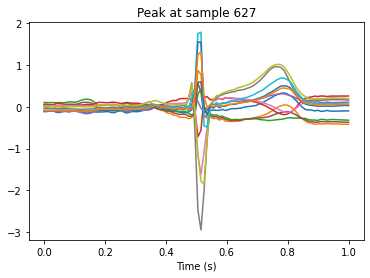

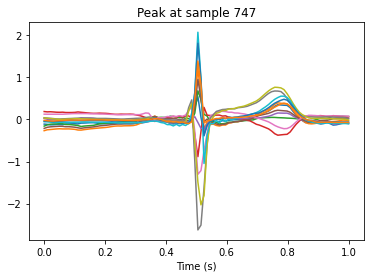

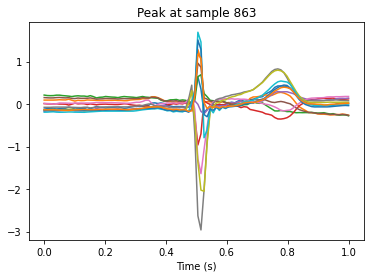

---------------- AFLT ---------------


<ipython-input-57-40e269af3911>:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-57-40e269af3911>:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-57-40e269af3911>:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


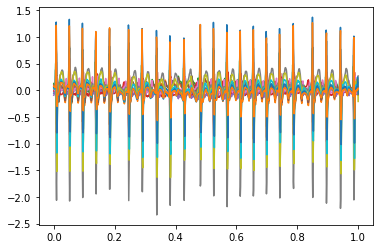

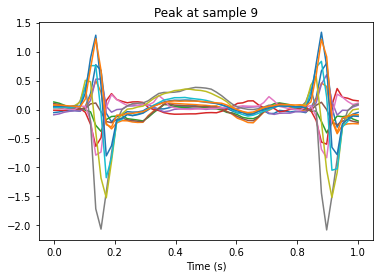

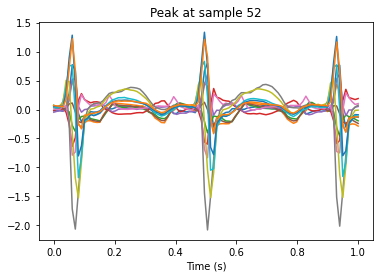

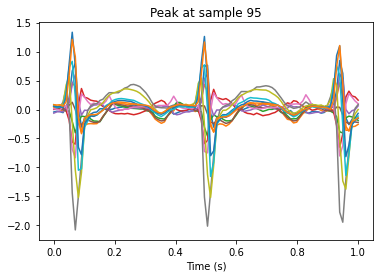

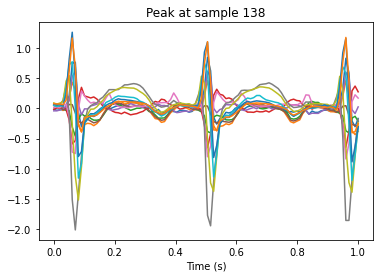

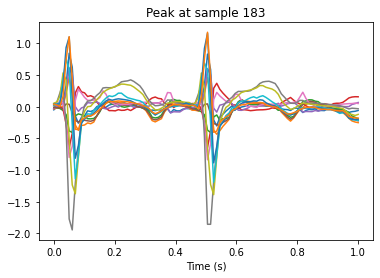

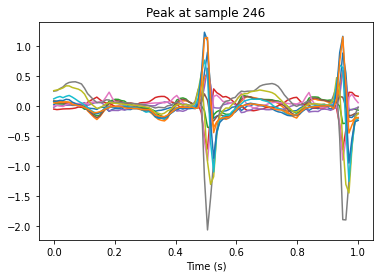

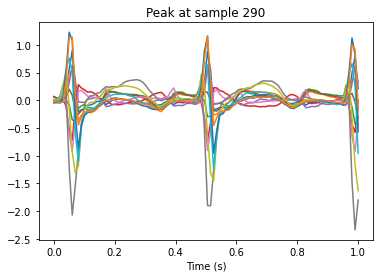

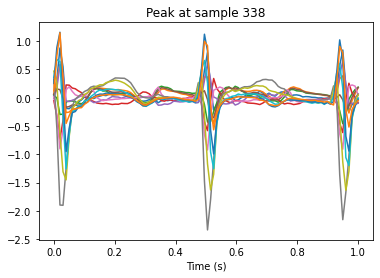

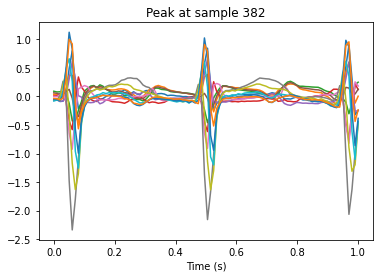

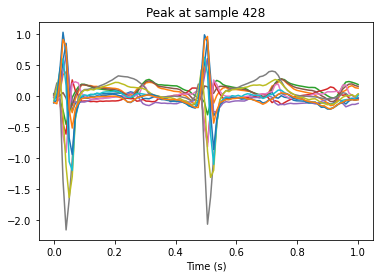

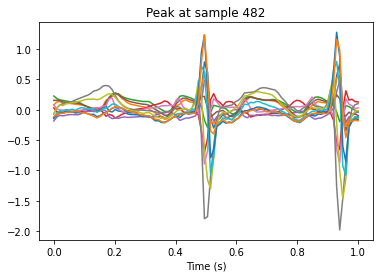

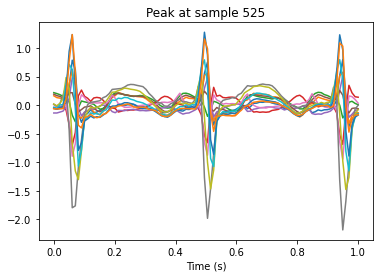

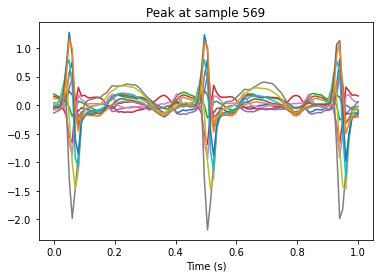

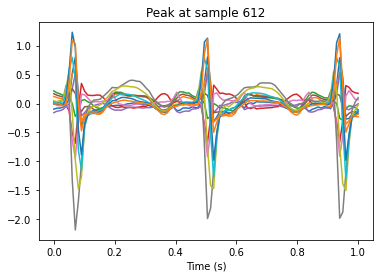

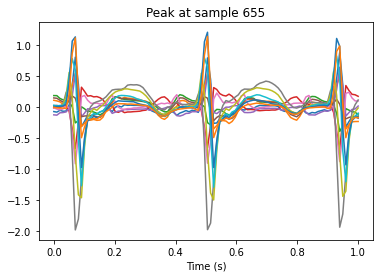

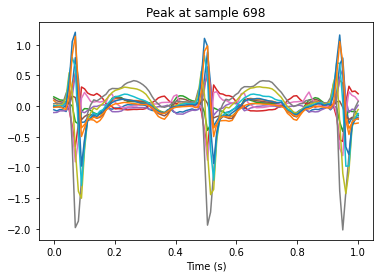

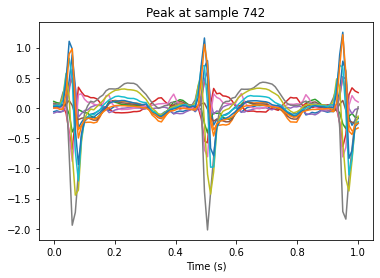

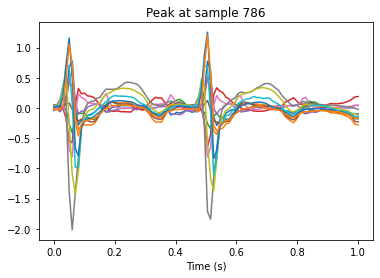

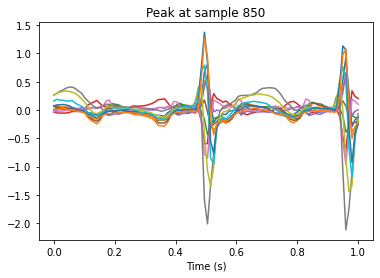

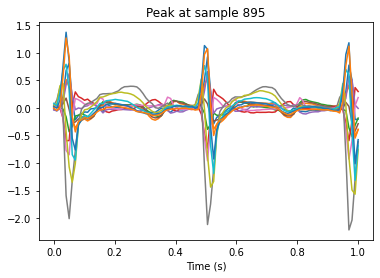

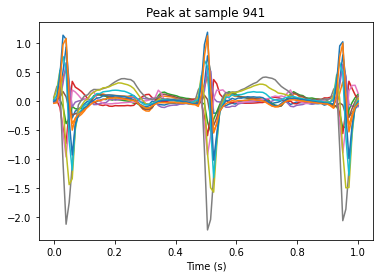

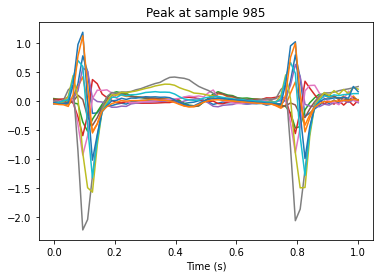

---------------- LVH ---------------


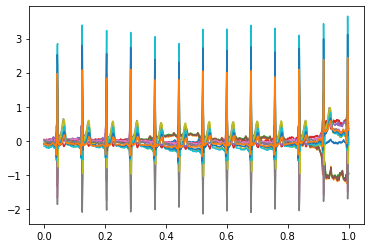

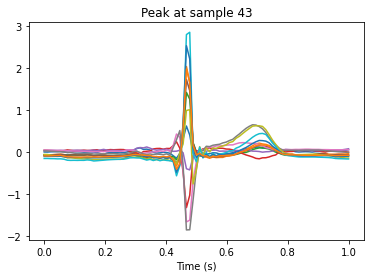

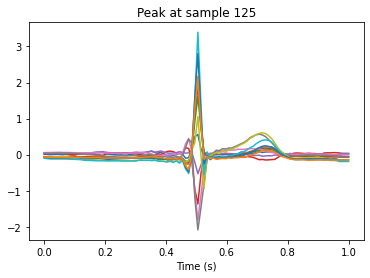

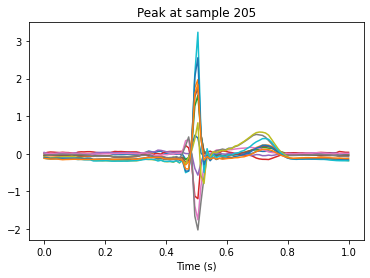

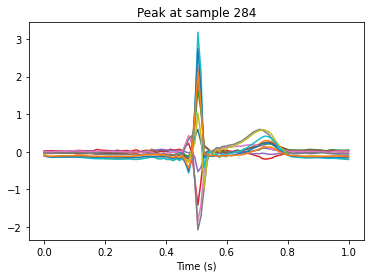

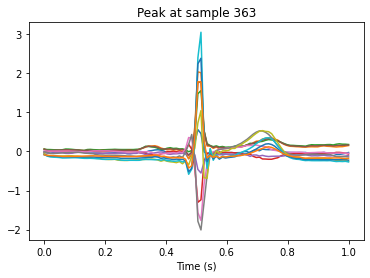

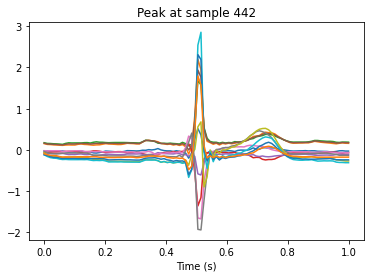

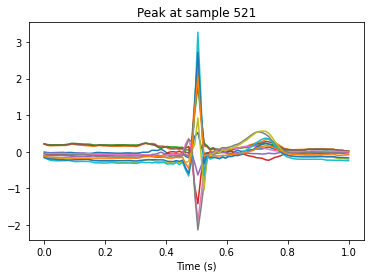

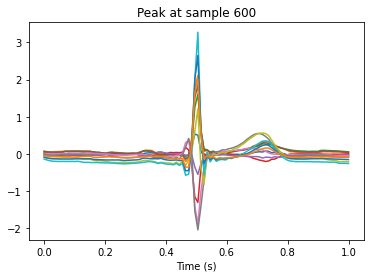

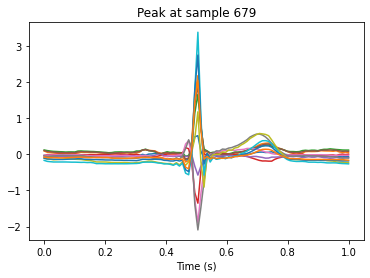

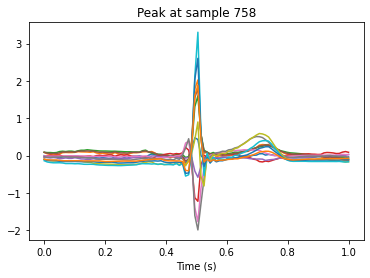

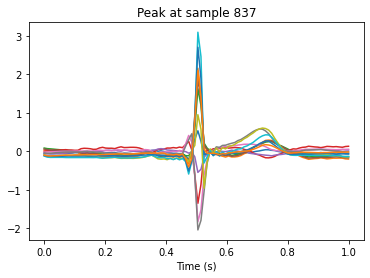

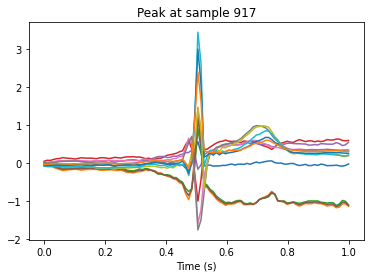

---------------- IMI ---------------


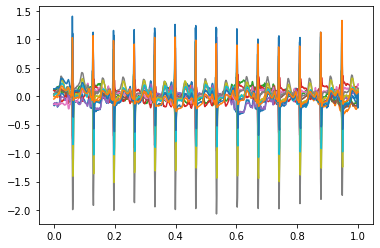

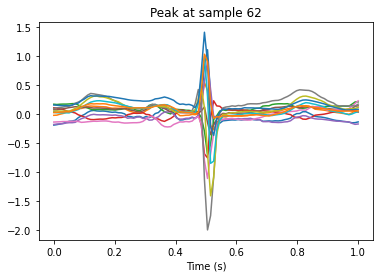

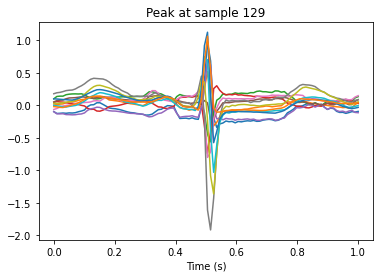

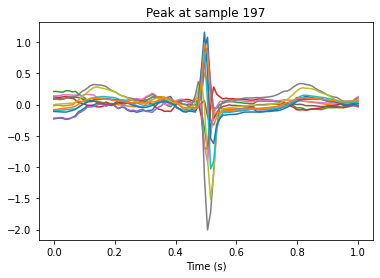

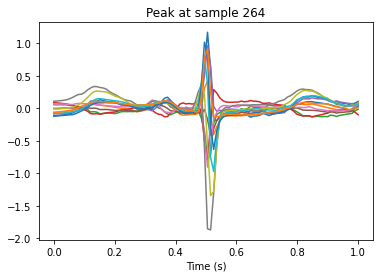

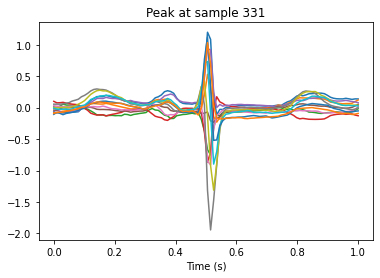

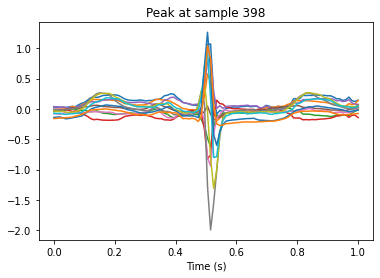

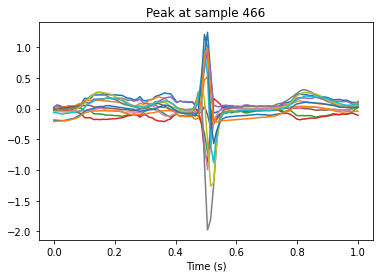

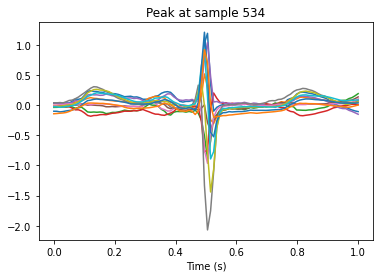

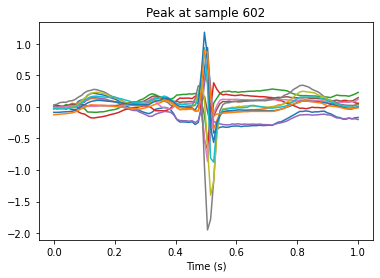

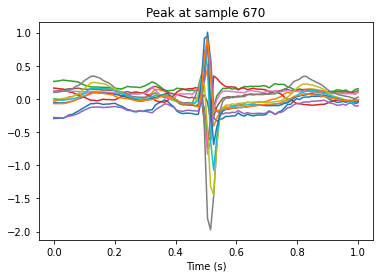

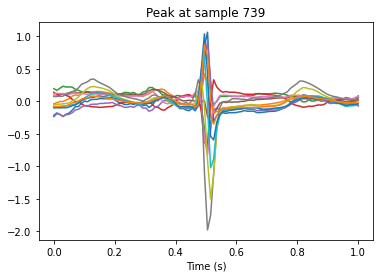

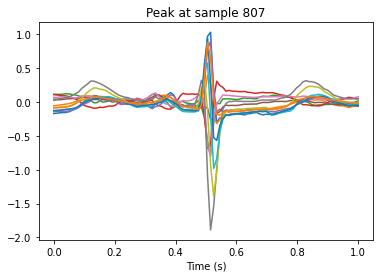

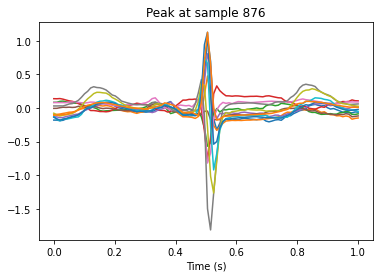

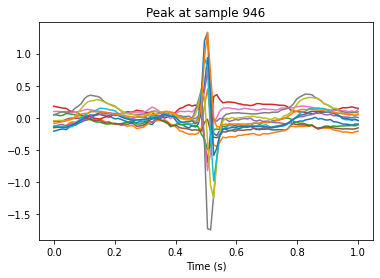

In [ ]:
###### let's plot different beat types and observe the whole strip across the 12 channels, as well as the beat neighborhood individually
beat_types = ['NORM', 'AFLT', 'LVH', 'IMI']

for beat in beat_types:
  print('---------------- '+ str(beat)+' ---------------')
  plot_ecg(Y, X, annots, beat_type = beat )

This demonstrates different arrhithmias will not only be noticeable in ecg strips, they may be noticed in the single QRS and its adjacencies at times. The atrial flutter peaks, for example, come accompanied by frequent beating and a raise in heartbeat, which is expected in atrial fibrillation and flutter cases[Carson, Peter E., et al. "The influence of atrial fibrillation on prognosis in mild to moderate heart failure. The V-HeFT Studies. The V-HeFT VA Cooperative Studies Group." Circulation 87.6 Suppl (1993): VI102-10.]. However, we may also notice that the QRS themselves show a jumpy baseline with low frequency oscillations.

## Extracting time domain features
Now we understand the data and annotations, we can proceed with extracting some time-domain features and metrics.

A basic time domain feature to tak from ECG is heartrate. Instant heartrate is calculated using the distance between adjacent QRS complexes, and may be useful to establish the baseline conditions of a patient and measure health parameters related to rest and sleep.[Sridhar, Niranjan, et al. "Deep learning for automated sleep staging using instantaneous heart rate." NPJ digital medicine 3.1 (2020): 106.]

Below I will calculate the 10-second averaged instant heartrate for different patients by looking at the distance between consecutive rpeaks in the 10 seconds recording. I will make an average for different arrhythmia types and plot them.
I will then do the same changing my window size to 5-seconds to observe if the observed instant heartrate is consistent at shorter time frames.

In [ ]:
def get_instant_heartrate(ecg_dictionary, signals, peaks_df, beat_type = 'NORM', sampling_freq = 100, rec = 1, seg_len=10):

  '''
  Function to find average instant heartrate for a certain beat type in the dataframe. 
  This function allows for windowing, so multiple instant heartrate measurements can be obtained from the same ecg strip.

  Args: 
  ecg_dictionary: Dict
    Dicitonary storing beat types, in our case from the database

  signals: array
    array containing all ecg strips.. 

  beat_type: String 
    Specifies the beat type we would like to plot, from the annotations in the ecg_dictionary. For example 'NORM' for a notmal beat.

  Sampling Freq: Integer
    Deffaults to 100, sampling frequency of database, used to calculate the time in the x axis. 

  rec: Int
    Deffaults to 1. Indicates the index of the record to show, out of the records identified with the desired beat type.
  
  seg_len: Int
    Defaults to 10 seconds, controls the length of the window used for instant heartrate.
  
  '''

  #finding all beats for the specified label

  indexes_of_interest = [beat_type in ecg_dictionary['scp_codes'][i].keys() for i in ecg_dictionary['scp_codes'].keys()]
  indexes_for_loop = [int(i) for i, x in enumerate(indexes_of_interest) if x]
  #fetch ecgs containing desired beat types
  ecg= signals[indexes_of_interest]

  average_hr = np.zeros([len(ecg), int(ecg.shape[-2]/ (seg_len * sampling_freq))])

  second_dim = int((ecg.shape[-2]/ (seg_len*sampling_freq)))
  #j indicates the ecg recording we are calculating averages for
  j=0
 
  for i in indexes_for_loop:
    #fetch peaks for the ecg
    
    peaks = np.array([int(peak) for peak in peaks_df['r_peaks'].iloc[i].split('[')[-1].split(']')[0].split()])

 

    #q indicates in which window or subsegment of that ecg we are at

    start=0
    
    for i in range(0, second_dim):
    
      window = peaks[start :] - peaks[start]
      #count, by the peak indexes, how much time has elapsed in this window, and take only the peaks that are withing the window time
      peaks_in_window = np.array(window[window.cumsum() <= seg_len *sampling_freq])
  
      #get mean r-r interval in seconds
      mean_diff= np.mean(np.diff(peaks_in_window))
      
      #storing beat, exception case for when we have more than one window present so array is two-dimensional
      if second_dim <= 1:
        average_hr[j] = mean_diff/sampling_freq
      else:
        average_hr[j, i] = mean_diff/sampling_freq
     

      #update starting peak for next window
      start += len(peaks_in_window.flatten())

    j+=1
    
  
  #divide length of window in seconds by time between beats to obtain beats per second
  beats_per_window = seg_len/average_hr
  
  #convert to beats per minute
  bpm= (60 * seg_len) / beats_per_window 
      
  return bpm
  

In [ ]:
#finding all beat_types to calculate their 10-s window heartrate
all_keys=[]

for i in Y['scp_codes'].keys():
  keys = list(Y['scp_codes'][i].keys())
  all_keys.append(keys)
all_keys = np.unique(list(itertools.chain(*all_keys)))

#storing average 10-s instant heart rate for different beat types

instant_hr = []
for beat_type in all_keys:

  result = get_instant_heartrate(Y, X, annots, beat_type = str(beat_type), seg_len =10)
  instant_hr.append(result)



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70]), <a list of 71 Text major ticklabel objects>)

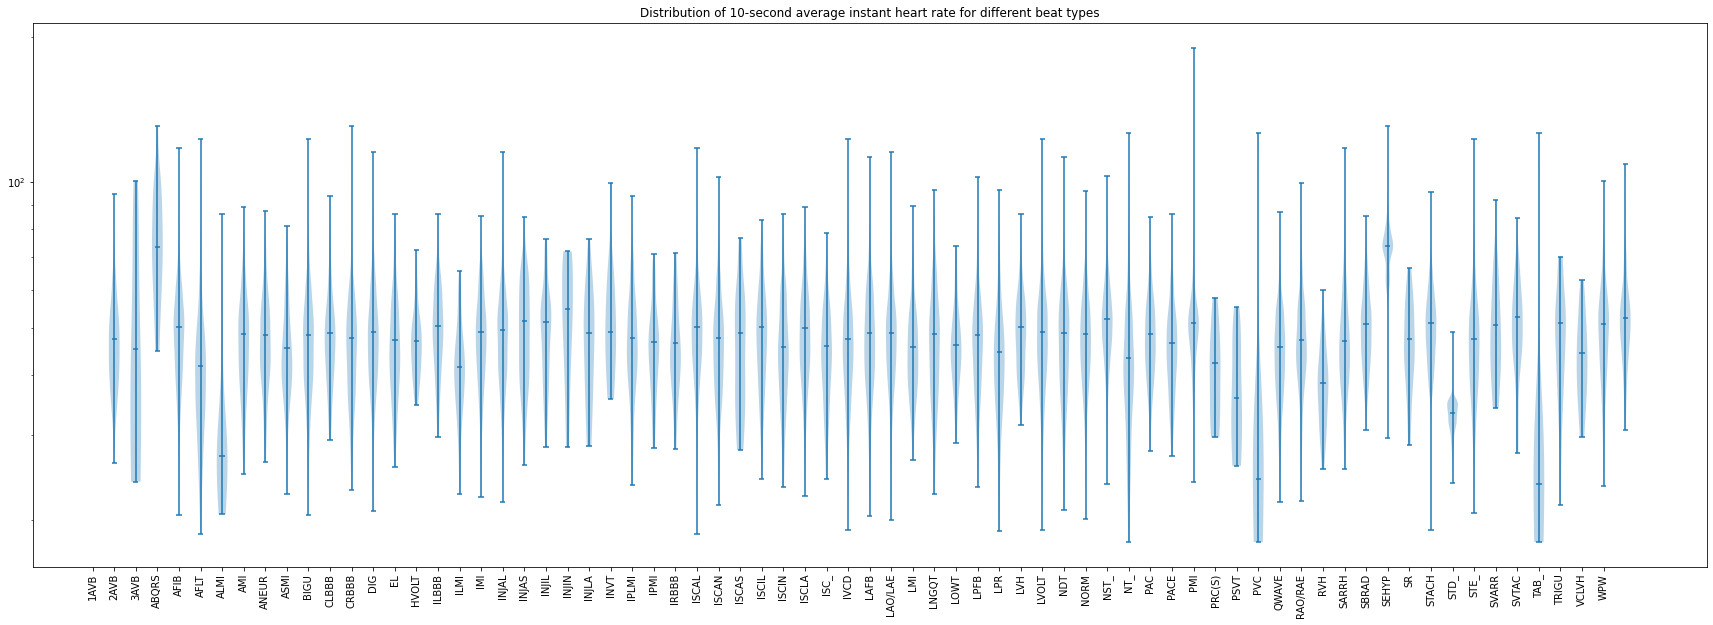

In [ ]:
#flattening list per procedure, preparing for violin plot
hr_list = [list(itertools.chain(*l)) for l in instant_hr]

#creagting violing plot to observe 10-second average heartrate across different types of beats
plt.figure(figsize=(30,10))
v= plt.violinplot(hr_list, showmedians = True)
plt.yscale('log')

ax = plt.gca()

plt.title('Distribution of 10-second average instant heart rate for different beat types')

#changing ticks to reflect the frequencies at which power is calculated

ax.set_xticks(range(len(all_keys)) );
ax.set_xticklabels(all_keys);
plt.yscale('log')
plt.xticks(rotation = 90)


this violin plot shows a distribution of the 10-second average instant heartrate for different types of beats. The logarithmic scale of the y axis allows us to see differences more clearly between high and low heart rates. The Y-axis is beats per minute. 

We can use this plot to find patterns that help us identify specific features for certsain arrhythmia types. For example, it's noticeable that the 'ALMI' , 'PVC' , 'PSVT', 'STD' and 'TAB' events casuse a reduction in the instant heartrate signal when averaged for 10-seconds. These annotations correspond to the events anterolateral myocardial infarction, ventricular premature complex, paroxysmal supraventricular tachycardia, non-specific T-wave depression, and T-wave abnormality. I would confirm this findings with an ECG technician or consultant to ensure they are consistent with their experience

Sometimes if we use a differently-sized window for calculating instant heartrate, we will be able to notice other features

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70]), <a list of 71 Text major ticklabel objects>)

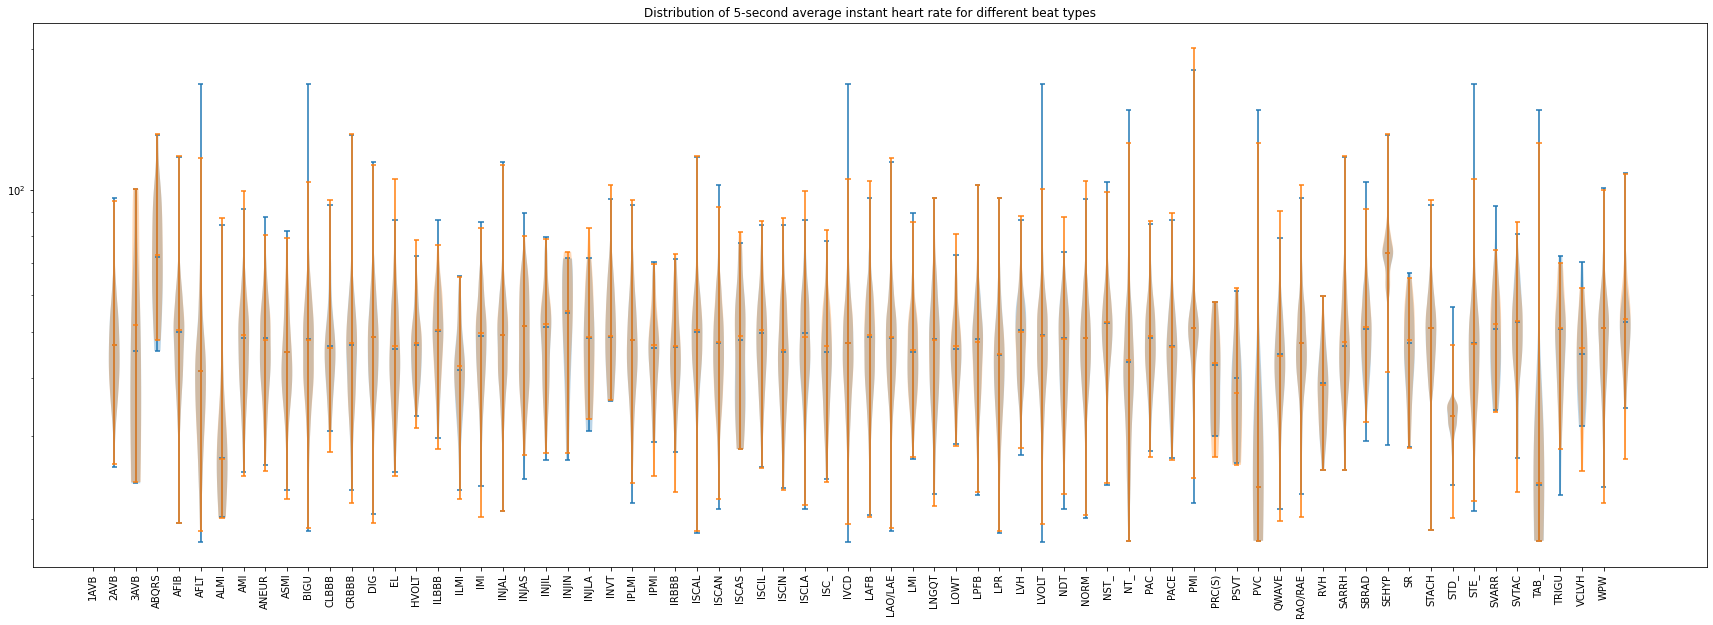

In [ ]:
#now let's try it again but with a shorter instant window to see if any differences become more apparent

instant_hr_window_1 = []
instant_hr_window_2 = []
for beat_type in all_keys:

  result = get_instant_heartrate(Y, X, annots, beat_type = str(beat_type), seg_len =5)
  instant_hr_window_1.append(result[:, 0])
  instant_hr_window_2.append(result[:, 1])

#we will plot the averages for both windows in an overlapping fashion

iteration=0
plt.figure(figsize=(30,10))

plt.violinplot(instant_hr_window_1, showmedians = True)
plt.violinplot(instant_hr_window_2, showmedians = True)
  

ax = plt.gca()
plt.title('Distribution of 5-second average instant heart rate for different beat types')
ax.set_xticks(range(len(all_keys)) );
ax.set_xticklabels(all_keys);
plt.yscale('log')
plt.xticks(rotation = 90)


Using a shorter window, the same patterns are preserved, indicating we can obtain equal measuremets without the need for so much data. The measurements were consistent across the two 5-second windows for each recording.

When predicting time- domain features for ecg, such as heart rate variability indexes and standard deviation of the r-r interval, a lot of times we need the beat classification because the intervals between normal-normal beats and the intervals between normal-ventricular beats can be widely different. Thus, a single ventricular beat in a large window can throw off the standard deviation of the r-r interval, which may render it less usable for establishment of baseline HRV metricws for a patient [Kleiger, Robert E., Phyllis K. Stein, and J. Thomas Bigger Jr. "Heart rate variability: measurement and clinical utility." Annals of Noninvasive Electrocardiology 10.1 (2005): 88-101.]


## Spectral analysis


So far I've demonstrated some examples of ECG and how to interpret it and extract heartrate from it. These examples are all in the time domain of the signal. However, ECG also contains frequency domain information, as the signal is composed of a summation of sinusoidal waves of different amplitudes and freuencies. Looking at the power of the signal at different frequencies may give us insight about what kind of beat we have, or what kind of multi beat event. Frequency domain features tend to be most useful for longer events because the larger the strip we work with, the better the frequency resolution, we we can look at a more detailed and exact frequency spectrum.

For a 1000 sample signal samples at 100Hz, we would have a resolution of 0.1Hz, up to 50Hz as per Nyquist's theorem. 

In [ ]:
#I will generate a function to obtain the power spectrums for a specified beat type.

def get_power_spect(ecg_dictionary, signals, peaks_df, beat_type = 'NORM', sampling_freq = 100):

  '''
  Function to find the power spectrums of ecgs of a specific beat type . 

  Args: 
  ecg_dictionary: Dict
    Dicitonary storing beat types

  procedure: string
    Name of the procedure from which we would like to calculate heartrate for. 

  beat_type: String 
    Specifies the beat type we would like to plot, from the annotations in the ecg_dictionary.

  Sampling Freq: Integer
    Deffaults to 100Hz, sampling frequency of database, used to measure the time in the x axis and important for frequnecy resolution. 
  
  '''

  #finding all beats for the specified label

  indexes_of_interest = [beat_type in ecg_dictionary['scp_codes'][i].keys() for i in ecg_dictionary['scp_codes'].keys()]
  ecg= signals[indexes_of_interest]


  #j indicates the ecg recording we are calculating the spectrum for
  j=0
 
  spect=np.zeros_like(ecg)

  for signal in ecg:

    for i in range(0, 11):
      #normalizing to compare power spectrums across channels of potentially different amplitudes
      signal[:,i] = signal[:,i]-np.min(signal[:,i])
      signal[:,i] = signal[:,i]/np.max(signal[:,i])

      #obtaining and storing power
      spect[j, :, i] = abs(fft(signal[:,i]))

    j+=1

  #storing corresponding frequencies
  xf= x=fftfreq(ecg.shape[-2], 1/sampling_freq)
  
  return spect, xf


(9517, 1000, 12)


Text(0.5, 0, 'Freq (HZ)')

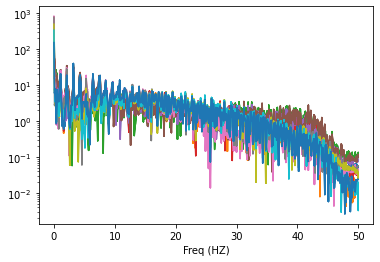

In [ ]:
spects, xf =get_power_spect(Y, X, annots)

#showing a sample spectrogram
plt.plot(abs(xf),spects[0,:])
plt.yscale('log')
plt.xlabel('Freq (HZ)')


This plot shows the overlapping power spectrum of the 12 channels of ecg. We can see the spectrum is somewhat consistent but might this not always be the case if certain leads pick up noise.

The Y-axis is logarithmic, whihc allows us to appreciate that lower frequencies tend to have higher power in ECG, which is consistent with literature findings [Murthy, Vrudhula K., et al. "Clinical usefulness of ECG frequency spectrum analysis." The Second Annual Symposium on Computer Application in Medical Care, 1978. Proceedings.. IEEE, 1978]. Because the sampling rate of the signal is 100Hz, we can only get the spectrum for frequencies up to 100Hz/2. Thus, we would not be able to observe noise at 60Hz spectrally with this plot.

(9517, 1000, 12)
(73, 1000, 12)


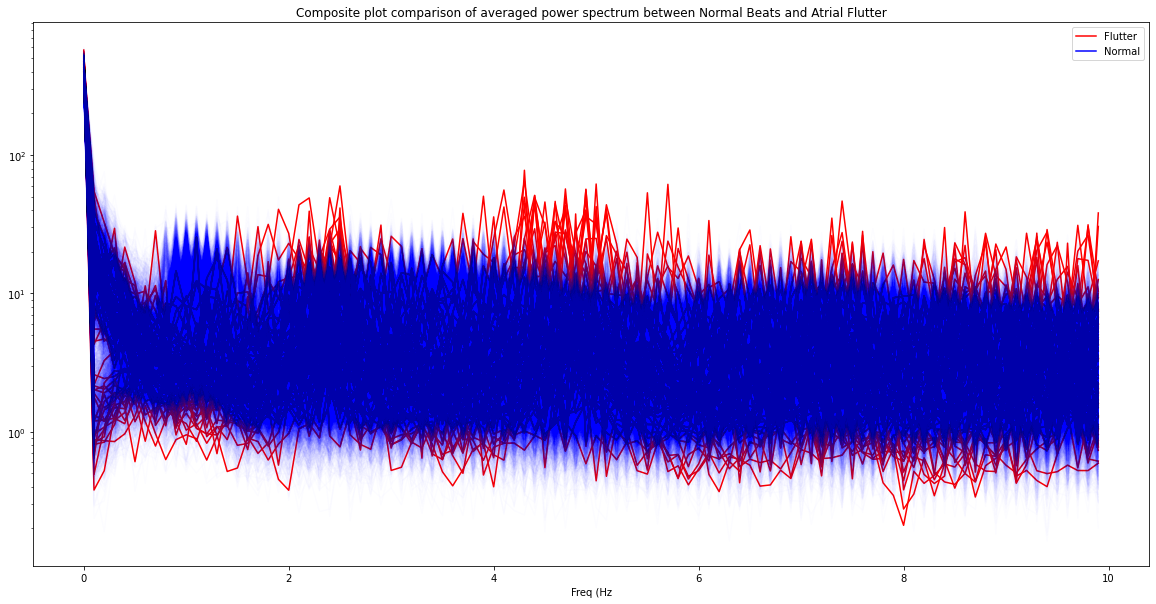

In [ ]:
#now, let's see the spectral distribution of low frequencies across different types of beats, as it seems low frequencies hold relevant information
#for this, we shall take the average power for each frequency per channel, for the same type of beat, and then plot it

comparison_keys= ['NORM', 'AFLT']
all_spects= []
for beat_type in comparison_keys:

  #getting average across 12 channels for each frequency
  result, xf= get_power_spect(Y, X, annots, beat_type = str(beat_type))
  all_spects.append([np.mean(result, axis=-1)])

#let's plot all the averaged spectrum for both beat types overlapped
plt.figure(figsize=(20, 10))
plt.title('Composite plot comparison of averaged power spectrum between Normal Beats and Atrial Flutter')
plt.plot(abs(xf[:100]), abs(all_spects[1][0].T[:100]), c='r');
plt.plot(abs(xf[:100]), abs(all_spects[0][0].T[:100]), c='b', alpha=0.01);
plt.yscale('log')
plt.xlabel('Freq (Hz')
plt.legend(['Flutter', 'Normal'])
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')

  The plot above shows a composite of the spectrums for a pathology case called atrial flutter and a normal beat. Each frequency spectrum is calculated using the average of the frequency spectrum across the 12 leads. We can observe some consistent patterns here, like power increasing on the 4-6Hz region for cases of flutter.  This is consistent with literature findings, which place AFIB peaks in the 5-6 Hz regions [Takahashi, Yoshihide, et al. "Organization of frequency spectra of atrial fibrillation: relevance to radiofrequency catheter ablation." Journal of cardiovascular electrophysiology 17.4 (2006): 382-388.]
If we used a higher sampling rate, it's likely the spectrum would be even mpore defined and less prone to noise, and it would allow for spectrum calculation at similar resolution with a shorter signal segment. 

  Extraction of power can be a useful feature when performing feature engineering and preprocessing data to feed to traditional machine learning algorithms.

## Validating Noise Annotations: Finding Noisy Beats using the power spectrum

One of the most useful aspects of spectral decomposition of signals is that it can sometimes help determine wether what we observe in a signal is noise. For example, if the signal power at 60 hZ is very high in comparison with other parts of the signal, it is very likely that this segment is particularly noisy. 

I will obtain the frequency spectrum for a groupo of QRS complexes, find the one with highest 60Hz power (powerline frequency where the recordings were taken) and plot it to see if it's in indeed noisy. 

In [ ]:
#we must use the 500Hz data if we want to observe 60Hz noise spectrally

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass. Thus lumps smaller arrhythmia subclasses into lasrger categories
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


The database noise label for noisiest normal signal: , alles,  
The database noise label for least noisy normal signal: nan


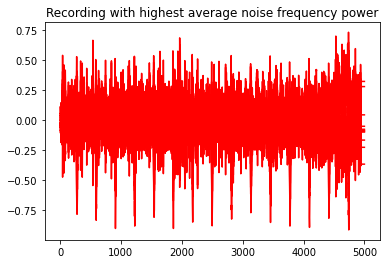

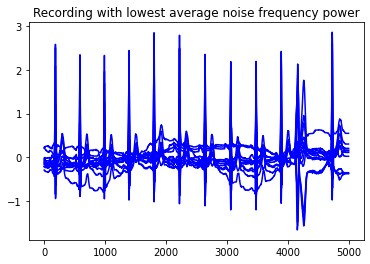

In [ ]:
annots = pd.read_csv('/content/drive/MyDrive/ptbxl_database.csv')


#getting average across 12 channels for each frequency
result, xf= get_power_spect(Y, X, annots, sampling_freq =500, beat_type = 'NORM')
result=np.mean(result, axis=-1)
#storing indexes in overall database containing normal beats
norm_indexes = ['NORM' in Y['scp_codes'].iloc[j].keys() for j in range(len(Y['scp_codes']))]

#taking 40 frequencies between 58-62Hz to measure noise at those indexes of the spectrum
noise_freqs = np.where(xf>58)[0][:40]

#looking at average power of those signals per recording
average_power = np.mean(result[:, noise_freqs], axis=-1)
#finding index of recording with maximum power at the frequencies of noise
max_noise = np.argmax(average_power)
#finding index of recording with minimum power at the frequencies of noise
min_noise = np.argmin(average_power)

plt.figure()
plt.title('Recording with highest average noise frequency power')
plt.plot(X[norm_indexes][max_noise], c= 'r')
plt.figure()
plt.title('Recording with lowest average noise frequency power')
plt.plot(X[norm_indexes][min_noise], c = 'b')


print('The database noise label for noisiest normal signal:' + str(Y['static_noise'][norm_indexes].iloc[max_noise]))
print('The database noise label for least noisy normal signal: ' +  str(Y['static_noise'][norm_indexes].iloc[min_noise]))

Using only the frequency spectrum, we were able to establish the signal with the highest noise frequency power in the dataset out of the normal beats. This corresponds to the noise label assigned in the dataset "alles", indicating noise is present in all leads. We can see this from the frequent oscillation seen across channels in the ecg plot.

Conversely, we plotted a signal with the lowest power spectrum at the noise signals. We can see the peaks are much more defined across channels, and the noise label in the dataset was 'nan', indicating the ecg strip does not contain noise across the 12 channels. 


Being able tomidentify noise is important because 
  - We may not want to make predicitons for a strip that is very noisy because they might be inaccurate
  - we can input noise measurements to amodel to help it make predictions and focus on features that are resilient even across recordings with noise
  - Any commmercially available algorithm must be prepared to deal with noise because, in wearable devices, we are exposed to noise all the time. It's important to identify it, quantify it and deal with it.

## Curating Dataset for Network Training

This classification task will tackle the problem of classifying multi-beat arrhythmia from 12-lead 10 second recordings of ecg. This is comparatively high
density data, some people in industry predict for much shorter time with way less leads. 
I will first identify recordings where the labels are assigned with high confidence (50% sure or more, as depicted by the probabilities provided for each beat class). Then I will identify the most common subclasses to create a dataset for training a network

In [ ]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

I will use this loop to save the recordings for which technicians or annotating algorithms are more than 50% sure of a beat class only, that way we train our network on data we can somewhat trust.

This is done by beat class, so they might be sure about a beat class being present in a strip but unsure about another. In this case, we will keep only
the beat class for which they were sure.


In [ ]:

labels = np.zeros(len(np.unique(list(itertools.chain(*Y['diagnostic_superclass'])))))

for i in range(len(Y)):
  spec_labels=[]

  #storing labels for each beat only if the annotator wa smore that 50% sure
  for key in Y.scp_codes.iloc[i].keys():
    
    if Y.scp_codes.iloc[i][key] > 50:
      spec_labels.append(key)
  labels.append(spec_labels)

labels=np.array(labels)

#ecg and corresponding multicall labels are stored in similar length arrays
data = [(x , signal) for x, signal in zip(labels, X) if x]

<ipython-input-569-3ecbbd9a55e1>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels=np.array(labels)


In [ ]:
#finding common labels in dataset, so we only train the network for more or less balanced classes
#i'll only make it pay attention to the first ten classes
common = pd.DataFrame({'data':itertools.chain(*Y.scp_codes)}).value_counts()[0:8].index.tolist()
common = [c[0] for c in common]

#initializing array for one-hot encoding of common labels
new_labels = np.zeros((len(data), len(common)))
ecg=np.zeros((len(data), 1000, 12))

#creating dictionary for one-hot encoded targets
enc=np.identity(len(common))
#now we can directly map each text anotation to a 1x10 one-hot encoded vector, representing each single class
enc_dict = {key : enc[i, :]  for (key, i) in zip(common, range(len(common)))}

#storing new labels with corresponding ecg, and one-hot encoding them

for i in range(len(data)):
  encoded_label = np.zeros(len(common))
 #one hot encoding with possibility for multiclass, which comes giv en by sum of single-class encoding
  #for example, envents 0 and 4 are present: [1,0,0,0,1] = [0,0,0,0,1] + [1,0,0,0,0]

  for key in data[i][0]:
    #if the label is balanced, mark it in the encoding so the network can learn it
    if key in common:
      encoded_label += enc_dict[key]
    #if key is not common, do not save it, we will get rid of it later as it will show up as a full-sero entry
    #unless a common beat is also present, in which case we focus on the common beat
    else:
      pass
  
  new_labels[i]= encoded_label
  ecg[i] = data[i][1]

#finding arrays that contain only zeros, which represent only uncommon beats
not_zeros = np.where(np.sum(new_labels, axis=-1) >0)

#getting rid of entries that only contain unbalanced classes
new_labels= new_labels[not_zeros]
ecg=ecg[not_zeros]

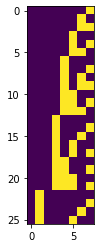

In [ ]:
#let's see if it worked

unique_classes = np.unique(new_labels, axis=0)
plt.imshow(unique_classes)

#this matrix is a representation of the multiple combinations of targets present in our
#one-hot encoded matrix. In some cases we only have one label per target, sometimes we have more
#and we don't have classes containing only zeros, so no uncommon beats

## Creating model architecture and training

I will create a model architechture to take in ECG chunks and classify them by beat types, according to the 8 most common beast types observed.

The nature of the model will be 1D convolutional, which is a good fit for extracting features from tabular data that may be impacted by data surrounding its position in the list. In our case, the tabular data is the signal amplitude describing ECG. I will train the model on 1000 sample chunks of ECG, centered around the QRS of interest, of 12-channels per strip. The 1D Convolution can recognize patterns in any part of the ECG chunk observed by the model, and across channels. ECG technicians often look at the surrounding of a qrs peak to observe features. To give the model this sort of behavior, we need a convolutional model rather than a dense one. 

I finished the model with an LSTM layer that is able to retain information from across different parts of the ecg tabular data regardless of distance (for a short signal sample like this), which can help the model draw relationships between parts of the signal. That way, we can extract local and overall features.

I used Parametric relu activations because in my experience they tend to work better in preventing the gradient loss, especially in data with varying ranges of magnitude. This is due to their learnable parameter that modifies the value of the derivative during back propagation. [A. D. Rasamoelina, F. Adjailia and P. Sinčák, "A Review of Activation Function for Artificial Neural Network," 2020 IEEE 18th World Symposium on Applied Machine Intelligence and Informatics (SAMI), Herlany, Slovakia, 2020, pp. 281-286, doi: 10.1109/SAMI48414.2020.9108717.
]

This is just a proof of concept to show how I would use ECG data to train a model, and thus I am using a very simplistic model. Many adjustments can be made to make it more sophisticated like:

  - Add additional data normalization.
  - Perform data augmentation and balance the number of labels. Right now we have a lot of normal beats because of the nature of the database. 
  - Add noise to further augment the data and help the network learn how to deal with noisy data it might see in real life. 
  - Add skip connections in the architechture to prevent gradient loss.
  -play with the activation function, layer sizes, and model depth. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ecg, new_labels, test_size=0.10, random_state=35)

In [ ]:
#adapting normaliozer to bring data to unit variance and zero-mean
normalizer1 = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer1.adapt(X_train)

input = Input(shape=(ecg.shape[-2], ecg.shape[-1]))

#normalization is learned as part of network training, so we don't have to normalize later
x= normalizer1(input)

#convolution 1D helps retain temporal awareness in the neighborhood of each point
x= Conv1D(32,(128),strides=10,padding='same',activation='PReLU')(x)
#dropout helps avoid overfitting, and batch noprmalization takes the data to similar ranges accross batches
x= Dropout(0.1)(x)
x=BatchNormalization()(x)

x= Conv1D(64,(32),strides=5,padding='same',activation='PReLU')(x)
x= Dropout(0.1)(x)
x=BatchNormalization()(x)

x= Conv1D(128,(32),strides=3,padding='same',activation='PReLU')(x)
x= Dropout(0.1)(x)
x=BatchNormalization()(x)

x= Conv1D(128,(16),strides=3,padding='same',activation='PReLU')(x)
x= Dropout(0.1)(x)
x=BatchNormalization()(x)
#LSTM gives network improved temporal awareness and allows it to connect patterns throughout the recording.
x=LSTM(50)(x)

x=Dense(new_labels.shape[-1], activation ='sigmoid')(x)

#adding checkpoint so model saves at lowest validation loss points automatically
#this is industry best practice but I've found not a lot of people do it :(
    
fpath = '/content/drive/MyDrive/IDOVEN_10CLASS_MODELL_100HZ.hdf5'
checkpoint = ModelCheckpoint(fpath, monitor='val_loss', verbose=1, \
                          save_best_only=True, save_weights_only=False, \
                          mode='auto', save_frequency=1)

#adding adaptive learning rate so we can enhance further learning at plateau points. Also great practice!
lrate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=7, min_lr=0.0000001)

model = Model(inputs= input, outputs= x)

optim= tf.keras.optimizers.Adam(learning_rate=1e-3 ,clipvalue=1.0)
#binary crossentropy allows the network to learn more than one class might be present in a label
model.compile(optimizer=optim , loss= 'binary_crossentropy', metrics=['accuracy'])


tf.config.run_functions_eagerly(True)
tf.experimental.numpy.experimental_enable_numpy_behavior()
print(model.summary())

#let's train on a sample of data only to speed up the process, as this is just exploratory
hist=model.fit(X_train[:4000], y_train[:4000], epochs=100, batch_size=10, validation_split=0.2, callbacks=[checkpoint, lrate])


Model: "model_355"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 normalization_4 (Normalizat  (None, 1000, 12)         25        
 ion)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 100, 32)           52384     
                                                                 
 dropout_13 (Dropout)        (None, 100, 32)           0         
                                                                 
 batch_normalization_13 (Bat  (None, 100, 32)          128       
 chNormalization)                                                
                                                                 
 conv1d_14 (Conv1D)          (None, 20, 64)            66

In [ ]:
from sklearn.metrics import classification_report
y_pred=model.predict(X_test)
print(classification_report(y_test, np.round(y_pred), target_names= common))

48/48 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

          SR       0.00      0.00      0.00         0
        NORM       0.81      0.92      0.86       866
       ABQRS       0.00      0.00      0.00         0
         IMI       0.20      0.16      0.18       118
        ASMI       0.53      0.35      0.42       160
         LVH       0.66      0.40      0.50       122
         NDT       0.38      0.19      0.26       186
        LAFB       0.64      0.70      0.67       166

   micro avg       0.70      0.66      0.68      1618
   macro avg       0.40      0.34      0.36      1618
weighted avg       0.66      0.66      0.65      1618
 samples avg       0.68      0.68      0.68      1618



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - This model can predict for the presence of more than one class per ECG strip.

 - This network is trying to identify subclasses. It is possible that features are shared between subclasses because beats belong to same hyperclass, making classification mkore challenging. We could instead start by training a model to distinguish between the 5 beat hyperclasses.


 - The classification report shows uneven performance across classes, with decent accuracy for Normal beat detection and somewhat performing for LVH and LAFB. This indicates to us that our dataset is likely unbalanced, ad seen by the support columm of the report.

 - Low recall in IMI and NDT indicate that the model is producing a lot of false negatives compared to the true positives for these classes, which can be a dangerous situation for clinical data because you don't want to mis dangerous beats.

 -Overall, the network stopped learning early because loss function stopped decreasing. Several factors could be causing this, it may be a dying gradient problem so i would add some skip connections, and we may need more dropout or L2 penalty to prevent overfitting. 

 -It may be the 12-channel 1000 sample data is too much for the network and incorporates turbulence and unpredictability in the data. A model could be trained on the average of the 12 leads. In reality, many models in industry should predict for one or two channels because it's what a lot of wearable monitoring devices have. 

 - Training a network is an iterative process, so I would implement one of these changes and re-train, and so on. 

# Appendix - A different problem: Beat by beat classification

I started this part of the notebook first because this is wha I do for work and it helped me organize my ideas as to what I wanted to showcase and what kind of procedures I am knowledgeable about. I approach it as a draft as it is not exactly the challenge data, but I would encourtage you to take a look as I think I show some techniques and procedures i apply on a saily basis in my area. 

These are all the same functions you see above, just had to make slight modifications. This functions deal with the MIT arrhythmia database from physionet. Here, we focus on analyzing the signal beat by beat, qrs by qrs rather than an entire strip at a time. To do this, we need labels for each qrs peak, which the 10-second sample database does not contain. 

## Loading ECG Data


I will use one of the most popular databases to demonstrate how to manipulate and interpret the ECG signal: The MIT arrhythmia database, which contains 30-minute recordings of multiple patients exhibiting a wide range of arrhythmias, using a dual channel lead. The ECG in this database is sampled at 360Hz, meaning that each 360 samples of the signal represent a second of the signal. The digitized signal has a range of 16 bit, or 2^12, meaning the values range from 0 to 4096 (2^12 -1)
When analyzing ECG, three things have to be considered:
1.- The signal itself.

2.- Benchmarks of the signal, such as R peaks, T waves or P waves.

3.- The type of event that a beat represents, which is typically determined around the QRS complex of tht beat. Once I load the singal I will give more insight into the parts of the QRS complex and their signifficance. 

In [ ]:
#Loading the ecg signal from a csv file, as well as the beat types at each qrs peak and the location of the qrs peaks from txt files
#I will create a dictionary so the signals, QRS times and beat annotations are easily accessible

#fetching all file names
paths=glob.glob('/content/drive/MyDrive/mitbih_database/*.csv')

#initializing lists to store ecg per channel and annotations
procedure_names = []
dfs=[]
for path in paths:
  
  #the path is the csv path, to obtain the txt file we need to modify it a bit
  path_base = path.split('.')[0]
  txt_path = path_base + 'annotations.txt'
  ecg =  pd.read_csv(path)
  annots= pd.read_fwf(txt_path)

  #storing rocedure identifier, e.g. 'm207'
  procedure_names.append(path_base[-3:])

  #storing ecg data and annotations
  df=pd.DataFrame({'CHA':ecg.iloc[:, 1], 'CHB': ecg.iloc[:, 2], 'Rpeaks': annots['Sample #'], 'Beats': annots['Type'] })
  dfs.append(df)

In [ ]:
'3using list comprehension to build dctionary containing procedure information with the procedure name as the keys'
data = {key: data for ( key, data) in zip(procedure_names, dfs)}

#visualizing our dictionary
data['100']

CHA   CHB  Rpeaks Beats
0        995  1011    18.0     +
1        995  1011    77.0     N
2        995  1011   370.0     N
3        995  1011   662.0     N
4        995  1011   946.0     N
...      ...   ...     ...   ...
649995  1009   928     NaN   NaN
649996   935   942     NaN   NaN
649997   889   951     NaN   NaN
649998   871   957     NaN   NaN
649999   768  1024     NaN   NaN

[650000 rows x 4 columns]

Now that our data is in a dictionary, I will write a function to help us visualize it. Some things to keep in mind are:

1.-We want to plot the signal at the site of our QRS typically, which is the site that tends to hold information about a heartbeat and whether its healthy. The QRS tends to be the part of highest amplitude of the clean signal, and represents the moment of ventricular contraction. The signal is larger at this point because of the large size of the contracting ventricle. 

2.- We want to plot the near neighborhood of the qrs peak to visualizd the P and T waves. These tend to be harder to detect in heuristic algorithms due to their lower amplitude with respect to the noise in the signal . 

3.- The type of beat. We want to be able to look up beats by their type and observe some examples of each to be able to analyze them.
  

## Plotting the Data

In [ ]:
def plot_ecg(ecg_dictionary, procedure, beat_type = 'N', sampling_freq = 360, rpeak = 1, seg_len=2000):

  '''
  Function to find and plot a random beat of a specified beat type in an ecg recording from the MIT database

  Args: 
  ecg_dictionary: Dict
    Dicitonary we created earlier to store ecg and beat types

  procedure: string
    Name of the procedure from which we would like to plot. For example, '232'. Used as a key to the dictionary

  beat_type: String 
    Specifies the beat type we want to plot. Options are: N for normal, 
    V for ventricular, A for atrial, R for left bundle branch block, and R for right bundle branch block.

  Sampling Freq: Integer
    Deffaults to 360, sampling frequency of database, used to measure the time in the x axis. 

  rpeak: Int
    Deffaults to 1. Indicates the index of the rpeak (out of the rpeaks containing the type of beat specified)
    that we want to plot. 
  
  seg_len: Int
    Defaults to 2000 and controls the size of the chunk of ECG we wish to plot, centered around the R-peak specified. 

  
  '''
  #Fetching channels for desired procedure
  cha= ecg_dictionary[procedure]['CHA']
  chb= ecg_dictionary[procedure]['CHB']

  #finding random beat of specified type for plotting, and corresponding rpeak.
  #limit for random generator will be the maximum rpeak index found in the procedure
  #only find random peak is peak has not been specfied by user

  peak_idx = np.where(ecg_dictionary[procedure]['Beats'] == beat_type)[0][rpeak]

 
  ecg_idx= (ecg_dictionary[procedure]['Rpeaks'][peak_idx]).astype('int32')
  x_axis=np.linspace(0, seg_len/sampling_freq , seg_len)

  
  plt.subplot(2, 1,1)
  plt.title('ECG CHA')
  plt.plot(x_axis, cha[int(ecg_idx-seg_len/2):int(ecg_idx+seg_len/2)])
  plt.xlabel('Time (seconds)')

  plt.subplot(2, 1,2)
  plt.title('ECG CHB')
  plt.plot(x_axis, chb[int(ecg_idx-seg_len/2):int(ecg_idx+seg_len/2)], c='r')
  plt.xlabel('Time (seconds)')
  plt.tight_layout()



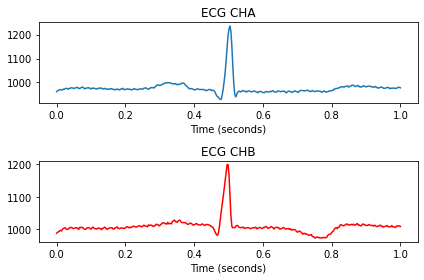

In [ ]:
#let's plot one second of data centered around a normal QRS in procedure m100
plot_ecg(data, '100', rpeak=380, seg_len=360)

We can clearly see the QRS complex in this example as it shows the greatest amplitude in the signal. In this case the complex is shown in both channels. Sometimes, the complex may be obvious in one channel and comletely missed in the other, due to noise or the positioning of one channel, or because of where the channel is with respect to where the heart is. Sometimes, the orientation of the peaks between different channels will be inverted due to positioning, so a good model must be able to deal with both types of data. 

In this example we can see the P wave right before the qrs especially in channel A, and the T wave afterwards. The signal is slightly noisy, with low amplitude oscillations of high frequency, possibly from electrical artifact.

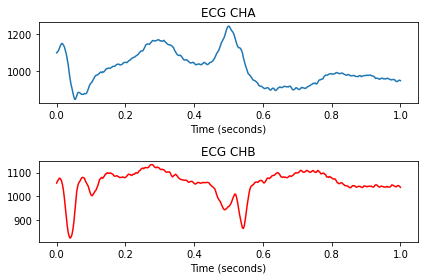

In [ ]:
#let's look at a ventricular in another procedure
plot_ecg(data, '106', rpeak=30, seg_len=360, beat_type= 'V')


This is a ventricular beats. These heartbeats are abnormal heartbeats from irregular electrical activity of the heart. Ventricular beats constitute the base of different arrhythmias and events. Isolated, they may not be very relevant, but if they are extremely frequent or occurr in certain patterns they may be concerning and should be detected. An algorithm should be able to process multiple beats individually and classify whether they are ventricular or normal, so that further assement into the frequency and combination of the ventricular beats can be done. I would say this is thebase of electrocardiographic detection. Traditionally, technicians tell apart ventriclar beats because they occurr too soon, or because they tend to have a wider QRS pea like the one on the example. 

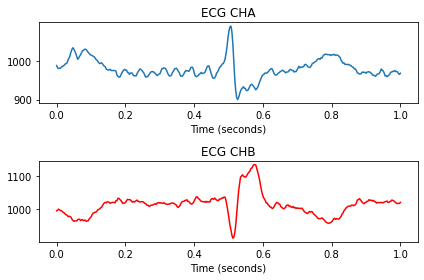

In [ ]:
#let's look at an atrial beat in another procedure
plot_ecg(data, '232', rpeak=30, seg_len=360, beat_type= 'A')

This one is an atrial beat, and an example of QRS peak inversion. Atrial beats are premature beats, in which the upper chambers of the heart or atrium initiate coontraction wihtout the ventricle having time to fill up. When the ventricule fills up, P waves occurr on the ECG. Thus, the ECG of an atrial beat will typically have a missing P wave. Atrial beats may be common in adults, but excessive frequency may be concerning, and they also shouold not be present on children. 

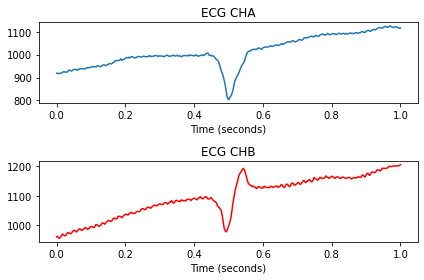

In [ ]:
#let's look at a Right bundle branch block beat
plot_ecg(data, '207', rpeak=1, seg_len=360, beat_type= 'L')


This left bundle branch block indicates there is a delay in conduction known as a bundle branch block, specifically on the left bundle. This delay can sometimes be reflected in the morphology of the beat. There is also right bundle branch block, which is a similar issue but on the opposite branch of the heart wall, ans because it's on the opposite side, the ECG signal also reflects it differently. 

The MIT database contains annotations for many different types of beats which can be found in [6]. What is most important is that there are a few types of beats a model should be able to recognize, because they constitute the base of arrhythmia diagnosis: Normal (N), Ventricular (V), Atrial(A), Junctional (J), Supraventricular (S), Fusion (F, fusion of ventricular and normal), and left and right bundle branch blocks (L and R, respectively). Detection of other signals such as atrial flutter or fibrillation requires looking at several qrs complexes because they are multibeat events.

## Time Domain Features

Besides analysis of beat tylpes and arrhythmias, some other basic parameters can be calculated when analyzing the ECG signal in the time domain. Heart rate telss us aboput how many times per minute the heart beats, and can provide insight on the health of the heart when compared to the base rhythm of a person. 

To calculate heartrate, we look at the QRS peaks. Each peak represents a heartbeat (ventricular contraction). If we cound the samples from one peak to the next and we know the sampling frequency of our device, we can calculate the time in second it takes from one beat to thew next, which can then be taken into beats per minute. 

The reality of the situation is that heartrate can vary a lot, so another useful parameter that is calculated is the oinstantaneous heartrate: a measure of beats per minute applied to a window of time that is shorter than a minute, even between two consecutive Rpeaks.

Below, I will show how to calculate instant heartrate for one of the procedures in MIT, as well as heartrate by windows of 4 seconds, and heartrate by minute.


In [ ]:
def calc_heart_rate(peaks, sampling_freq = 360, window_size = 1, overlap=0):

  '''
  Function to calculate heartrate given by successive QRS complexes.

  Peaks: Array
    Consecutive array of indexes for the Rpeaks, which will be used to cslculate the samples between rpeaks

  sampling_freq: Int
    Defaults to 360Hz. Sampling frequency of the signal, used to calculate the duration of a number of signal samples between peaks. 

  window_size: Int
    Defaults to 1. Seconds of recordinfg used for calculation of heartrate. Instant heartrate is represernted by smaller intervals.

  overlap: int
    Defaults to 0. Indicates the seconds of overlap between windows. Allows for smoother transitions between adjacent windows.

      '''
    #the difference between consecutive rpeak indexes gives is the samples beatween each, and thus the duration.
  
  padded_diff = np.zeros(len(peaks))
  time=np.zeros(len(peaks))

  #initialize counters and second indexers

  p=1 
  i=1
  next_window_overlap_count = 0
  next_window_overlap_beats = 0 

  while p < (len(peaks)- overlap):

      #count peak indexes until we have reached the end of alln peaks in window
      time_count=0

      #updating stored values of the qrs differen es in the overlap region, stored from previous window
      prev_window_overlap_count = next_window_overlap_count
      prev_window_overlap_beats = next_window_overlap_beats
      
      #resetting counters used to keep track of window lenfgth
      next_window_start =0
      next_window_overlap_count = 0
      next_window_overlap_beats = 0 



      #register time at the start of the window, used in plotting
      time[i] = peaks[p] / sampling_freq
  
      #time count looks at peak indexes to know the time and whether our window is transcurred or not
      while time_count < window_size:

       #interval between consecutive peaks gives us the time transcurred
       #we will store it so we don't have to do the summation later
       interval = abs(peaks[p] - peaks[p-1]) / sampling_freq
       time_count+=  interval
       p+=1


       #if we are in the overlap region at end of the window, store these values for the next calculation
       if window_size - time_count < overlap:
         next_window_overlap_count += interval
         next_window_overlap_beats +=1
     #time count tells us the time transcurred in total and p-1 indicates how many beats we had
     #this is the beat number for our window! 
     #this tells us in average how long we take between heartbeats for a window
      padded_diff[i] = (time_count + prev_window_overlap_count ) / (p-i + prev_window_overlap_beats)
      

      #overlap determines the number of beats in the current window we still re-run through the next window
      i = p 
    
  #calculate beats per window, use only non-zero parts of the array. 
  beats_per_window = window_size / padded_diff [padded_diff >0]

  #using the mean intervals between rpeaks for the calculated windows, extrapolate how
  #many beats we would get in a minute with that qrs interval
  bpm = (60 * window_size) / beats_per_window 


 
                                                                    
  return bpm, time[padded_diff >0]

Text(0.5, 1.0, '20-beat Average HR, 30-second overlap')

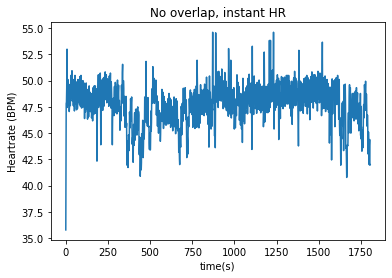

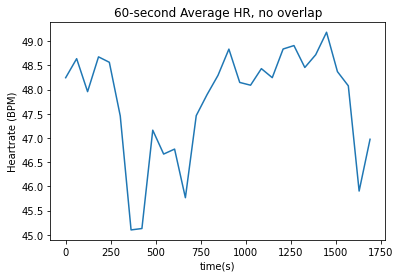

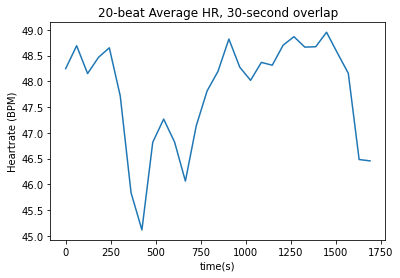

In [ ]:
#calculate instant heartrate
peaks= data['100']['Rpeaks']
bpm, time = calc_heart_rate(peaks)

plt.figure()
plt.plot(time, bpm)
plt.xlabel('time(s)')
plt.ylabel('Heartrate (BPM)')
plt.title('No overlap, instant HR')


#calculate heartrate with an overlap
peaks= data['100']['Rpeaks']
bpm, time = calc_heart_rate(peaks, window_size=60, overlap = 0)

plt.figure()
plt.plot(time, bpm)
plt.xlabel('time(s)')
plt.ylabel('Heartrate (BPM)')
plt.title('60-second Average HR, no overlap')

#calculate heartrate for minute-window peaks with 20-second overlap
peaks= data['100']['Rpeaks']
bpm, time = calc_heart_rate(peaks, window_size=60, overlap =30)


plt.figure()
plt.plot(time, bpm)
plt.xlabel('time(s)')
plt.ylabel('Heartrate (BPM)')
plt.title('20-beat Average HR, 30-second overlap')


Above we have plots for the heartrate of the individual in recording m100 at different time resolutions. The first pklot id the highest resolutin tested, in which heartrate in BPM is measured for 1-second windows of recording. This allows us to appretiate sudden changes in heart rate, even if the chsange didn't last a whole minute. Thius is insightful to technicians and algorithms when trying to assess certain types of arrhythmias, and might give hints about where cardiac events are occurring. 

The bigger the window size, the less we will be able to notice sudden changes in heartrate as we average for segments of recording. The one-minute window graph, for example, misses some of the sudden increases observed netween seconds 750-1000 of the recording. Using an overlapped window might help if for any reason we desire to have a smoother heartrate siugnal, as heartrate is calculated for windows taking in count the region of overla=p with the previous window, althpough large overlaps might negaively affect the accuracy of the measurement of heartrate.

All beats in recording m100 are normal beats. However, for several heartrate related measurements, it is recommended removing ventricular or ectopic beats. For example, to calculate indexes of heartrate variability such as the standard deviation of the beats in 5-minute windows, it is recommended to not use intervals including ventricular beats because a single ventricular beat may throw off the deviation and comletely change the measurement [7]. Similarly, presence of abnormal intervals due to ectopic beats will have high impact on the frequency domain metrics of heart rate variability, and thus should be removed for establishment of a patient baseline or patient-patient comparisons.


## Filtering and Spectral Analysis 

So far I've demonstrated some examples of ECG and how to interpret it. These examples are all in the time domain of the signal. However, ECG also contains frequency domain information, as the signal is composed of a summation of sinusoidal waves of different amplitudes and freuencies. Looking at the power of the signal at different frequencies may give us insight about what kind of beat we have, or what kind of multi beat event. Frequency domain features tend to be most useful for longer events.

In [ ]:
#let's first write a function to plot the frequency spectrum of a beat

def plot_ecg_freq(ecg_dictionary, procedure, beat_type = 'N', sampling_freq = 360, rpeak = 1, seg_len=2000):

  '''
  Function to find and plot a random beat of a specified beat type in an ecg recording from the MIT database

  Args: 
  ecg_dictionary: Dict
    Dicitonary we created earlier to store ecg and beat types

  procedure: string
    Name of the procedure from which we would like to plot. For example, '232'. Used as a key to the dictionary

  beat_type: String 
    Specifies the beat type we want to plot. Options are: N for normal, 
    V for ventricular, A for atrial, R for left bundle branch block, and R for right bundle branch block.

  Sampling Freq: Integer
    Deffaults to 360, sampling frequency of database, used to measure the time in the x axis. 

  rpeak: Int
    Deffaults to 1. Indicates the index of the rpeak (out of the rpeaks containing the type of beat specified)
    that we want to plot. 
  
  seg_len: Int
    Defaults to 2000 and controls the size of the chunk of ECG we wish to plot, centered around the R-peak specified. 

  
  '''
  #Fetching channels for desired procedure
  cha= ecg_dictionary[procedure]['CHA']
  chb= ecg_dictionary[procedure]['CHB']

  #finding random beat of specified type for plotting, and corresponding rpeak.
  #limit for random generator will be the maximum rpeak index found in the procedure
  #only find random peak is peak has not been specfied by user

  peak_idx = np.where(ecg_dictionary[procedure]['Beats'] == beat_type)[0][rpeak]

 
  ecg_idx= (ecg_dictionary[procedure]['Rpeaks'][peak_idx]).astype('int32')
  beat_a = cha[int(ecg_idx-seg_len/2):int(ecg_idx+seg_len/2)]
  beat_b= chb[int(ecg_idx-seg_len/2):int(ecg_idx+seg_len/2)]
  x_axis=np.linspace(0, seg_len/sampling_freq , seg_len)

  #calculating frequency domain features, depends on length of sement and sampling frequency

  cha_yf = fft((beat_a-np.min(beat_a)))
  chb_yf = fft((beat_b-np.min(beat_b)))

  #frequnecy axis given by:
  xf = abs(fftfreq(seg_len, 1/sampling_freq))

  plt.figure(figsize=(10,6))
  #plot time domain
  plt.subplot(2, 2,1)
  plt.title('ECG CHA')
  plt.plot(x_axis, beat_a)
  plt.xlabel('Time (seconds)')

  plt.subplot(2, 2,3)
  plt.title('ECG CHB')
  plt.plot(x_axis, beat_b, c='r')
  plt.xlabel('Time (seconds)')
  plt.tight_layout()

  #plot frequency domain

  plt.subplot(2, 2,2)
  plt.title('Power spectrum CHA')
  plt.plot( xf, abs(cha_yf))
  plt.xlabel('Frequency (Hz)')
  plt.xlim(0,40)

  plt.subplot(2, 2,4)
  plt.title('Power spectrum CHB')
  plt.plot( xf, abs(chb_yf))
  plt.xlabel('Frequency (Hz)')
  plt.xlim(0,40)

  plt.tight_layout()
  plt.show()



----------- Normal ------------


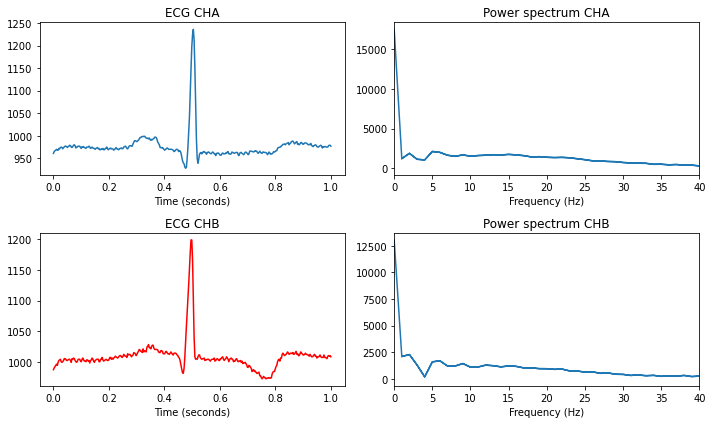

----------- Ventricular ------------


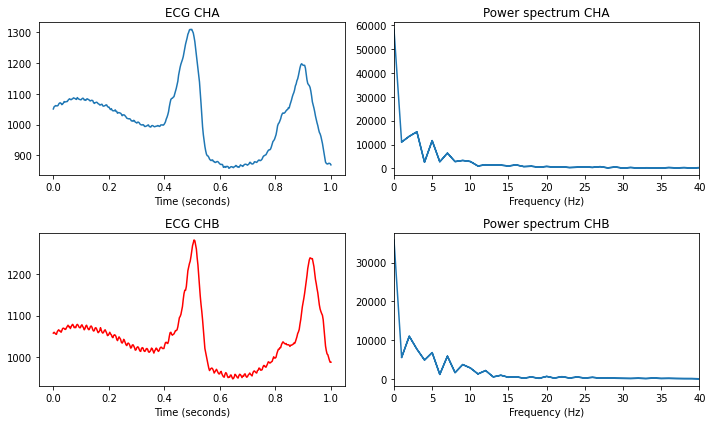

In [ ]:
#let's look at the frequency spectrum of several beats

print('----------- Normal ------------')
plot_ecg_freq(data, '100', rpeak=380, seg_len=360)

print('----------- Ventricular ------------')
plot_ecg_freq(data, '207', rpeak=30, seg_len=360, beat_type='V')

In this example, we can see a ventricular beat has much higher power in the low frequencies. It's possible this may have to do with the width of the QRS peak. To see if this is a trend across many beats, let's create a function and pot the distribution of the power for multiple ventricular beats versus multiple normal beats.

Here we are looking at frequencies up to 400Hz, but the spectrum goes until 180Hz which is half of the sampling frequency as per the Nyquist theorem. However, in practice and in industry, we typically observe frequencies up to 1/4 or 1/5 of the sampling frequency as we loose resolution to capture events of high frequency. 

In [ ]:
def find_beats(ecg_dictionary, procedure, beat_type = 'N', len_segment=720):

  '''
  Function to find specified beats in a procedure

  Args: 
  ecg_dictionary: Dict
    Dicitonary we created earlier to store ecg and beat types

  procedure: string
    Name of the procedure from which we would like to plot. For example, '232'. Used as a key to the dictionary

  beat_type: String 
    Specifies the beat type we want to plot. Options are: N for normal, 
    V for ventricular, A for atrial, R for left bundle branch block, and R for right bundle branch block.
  
  len_segment: Int
    Defaults to 720, indicates how big of a chunk of ecg we want to extract for a certain beat.

  '''
  half_segment=len_segment//2
  cha= ecg_dictionary[procedure]['CHA']
  chb= ecg_dictionary[procedure]['CHB']

  #Finding all beats of the specified type
  index = np.where(ecg_dictionary[procedure]['Beats'] == beat_type)[0]
  all_beats_cha=np.zeros([len(index), len_segment])
  all_beats_chb=np.zeros([len(index), len_segment])

  #storing beats
  p=0
  for i in ecg_dictionary[procedure]['Rpeaks'][index].astype('int64'):

    seg_a = cha[(i-half_segment) if (i>half_segment) else 0 : i+half_segment if (i+half_segment)< len(cha) else len(cha)]
    seg_b = chb[(i-half_segment) if (i>half_segment) else 0 : i+half_segment if (i+half_segment)< len(chb) else len(chb)]

    all_beats_cha[p, :len(seg_a)]= seg_a
    all_beats_chb[p, :len(seg_b)]= seg_b
    p+=1

  return all_beats_cha, all_beats_chb

In [ ]:
N_beats_a, N_beats_b = find_beats(data, '119')
V_beats_a, V_beats_b = find_beats(data, '119', beat_type = 'V')

#print to check that the data is balanced. 
print(len(N_beats_a), len(V_beats_a))

#720 is the amount of frequencies for which we have the power measurement
a_power_specs_N = np.zeros([len(N_beats_a), 720])
b_power_specs_N = np.zeros([len(N_beats_a), 720])

i=0
for (abeat, bbeat) in zip(N_beats_a, N_beats_b):
  a_yf = abs(fft((abeat-np.min(abeat))))
  b_yf = abs(fft((bbeat-np.min(bbeat))))

  #storing spectrums

  a_power_specs_N[i]=a_yf
  b_power_specs_N[i]=b_yf
  i+=1

#averaging column wise to obtain average power for normal beats per frequency
a_average_N= np.mean(a_power_specs_N, axis=0)
b_average_N= np.mean(b_power_specs_N, axis=0)

#do the same for the ventricular beats

a_power_specs_V = np.zeros([len(N_beats_a), 720])
b_power_specs_V = np.zeros([len(N_beats_a), 720])

i=0
for (abeat, bbeat) in zip(V_beats_a, V_beats_b):
  a_yf = abs(fft((abeat-np.min(abeat))))
  b_yf = abs(fft((bbeat-np.min(bbeat))))
 


  #storing spectrums

  a_power_specs_V[i]=a_yf
  b_power_specs_V[i]=b_yf
  i+=1

#averaging column wise to obtain average power for normal beats per frequency
#a_average_V= np.mean(a_power_specs_V, axis=0)
#b_average_V= np.mean(b_power_specs_V, axis=0)

1543 444


In [ ]:
#controls how many frequencies we want to plot
max_freq=40
samp_freq=360
len_segment=720

xf = fftfreq(len_segment , 1/samp_freq) #obtaining frequencies corresponding to each power

#storing power for each frequency on each recording
powers = np.zeros([ max_freq, len(a_power_specs_N),  4])

for frequency in range(len(powers)):

  #storing the power for that frequency for all beats, done for normals and ventriculars per channel
  powers[frequency][:,0] = a_power_specs_N[:, frequency]
  powers[frequency][:,1] = b_power_specs_N[:, frequency]
  powers[frequency][:,2] = a_power_specs_V[:, frequency]
  powers[frequency][:,3] = b_power_specs_V[:, frequency]




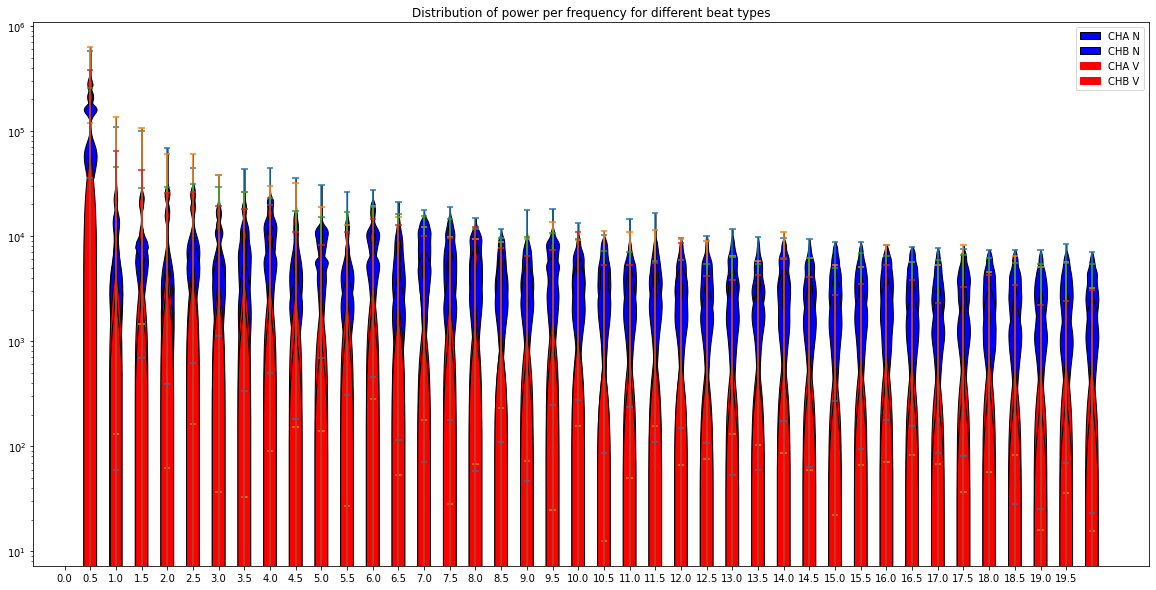

In [ ]:
plt.figure(figsize=(20,10))

#powers array contains the power for each frequency for Normal beats in A and b and ventricular beats in A and B
#lets plot a distribution of the powers for each case to compare how the power changes between npormal and ventricular
for i in range(powers.shape[-1]):
  v= plt.violinplot(powers[:max_freq, :, i].tolist())

  #for the first two channels, whhich represent our normal beats in A and B, we shall use blue
  if i< 2:
    for pc in v['bodies']:
        pc.set_facecolor('b')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
  #For the last channels of the array, which are the ventricular beat powers in A and B, we shall use red
  else:
    for pc in v['bodies']:
        pc.set_facecolor('r')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

plt.legend(['CHA N', 'CHB N', 'CHA V', 'CHB V'])

#code to change legend taken from https://stackoverflow.com/questions/23698850/manually-set-color-of-points-in-legend
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[2].set_color('red')
leg.legendHandles[3].set_color('red')
plt.title('Distribution of power per frequency for different beat types')

#changing ticks to reflect the frequencies at which power is calculated
ax.set_xticks(range(0,max_freq))
ax.set_xticklabels(i for i in xf [:max_freq] );
plt.yscale('log')

  On the x axis we can see the first 20 frequencies, and the violin plots represent the power of that frequency for Normal (Blue) and ventricular (Red) beats. It seems that for this procedure there is a consistent trend where the power of ventricular beats is distributted towards the lower side. This goes against the trend observed initially when we looked at one normal beat power for procedure m100 compared to one ventricular from procedure m207. This goeas to show that although power may be an insightful metric, it is highly variable between individuals and sometimes withn the same individual on different parts of the signal. 
  
  Using different segment lengths for the QRS complex chunks will give us different frequency resolutions. In short, this allows for more frequencies to show up in the spectrum, which might help make the spectrum of a ventricular beat more noticeably different than that of a normal beat. Our segment length here is 720 samples for a sampling frequency of 360Hz, so our frequnecy resolution is 360Hz/720 = 0.5Hz, meaning we can see frequencies on the spectrum in increments of 0.5. If we use a 1740 sample chunk, for example, our frequency resolkution would be smaller and we would be able to see an even more detailed spectrum.

## using spectral properties to identify noise

I will obtain the frequency spectrum for a groupo of QRS complexes, find the one with highest 60Hz power (powerline frequency where the recordings were taken) and plot it to see if it's in indeed noisy. 

1586


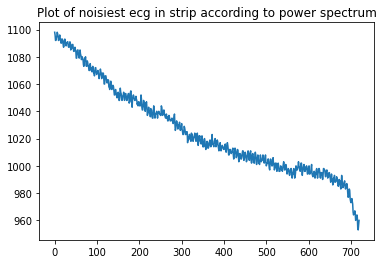

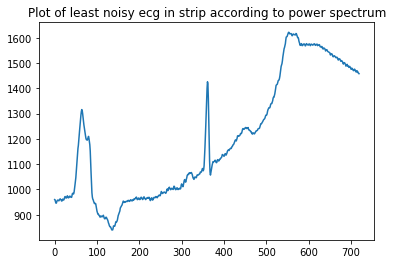

In [ ]:
samp_freq=360
len_segment=720

N_beats_a, N_beats_b = find_beats(data, '208', beat_type = 'N' , len_segment=len_segment)

#print to check that the data is balanced. 
print(len(N_beats_a))

xf = fftfreq(len_segment , 1/samp_freq) #obtaining frequencies corresponding to each power

#720 is the amount of frequencies for which we have the power measurement
a_power_specs_N = np.zeros([len(N_beats_a), len_segment])
b_power_specs_N = np.zeros([len(N_beats_a), len_segment])

i=0
for (abeat, bbeat) in zip(N_beats_a, N_beats_b):
  
  #normalizing signal between 0 and 1 for beat-beat power comparison
  abeat= abeat-np.min(abeat)
  abeat/= np.max(abeat)
  
  bbeat= abeat-np.min(bbeat)
  bbeat/= np.max(bbeat)
  
  a_yf = abs(fft((abeat)))
  b_yf = abs(fft((bbeat)))

  #storing spectrums

  a_power_specs_N[i]=a_yf
  b_power_specs_N[i]=b_yf
  i+=1

#find index of frequency closest to 60Hz
noise_index = np.argmin(abs(xf - 60))

##the 60Hz power is at noise index, now use argmax to find recoprding with highest power at that index in the spectrum
max_noise_beat = np.argsort(a_power_specs_N[:, noise_index])[-1]

plt.figure()
plt.title('Plot of noisiest ecg in strip according to power spectrum')
plt.plot(N_beats_a[max_noise_beat])

#compare to minimum noise beat
min_noise_beat = np.argsort(a_power_specs_N[:, noise_index])[0]

plt.figure()
plt.title('Plot of least noisy ecg in strip according to power spectrum')
plt.plot(N_beats_a[min_noise_beat])

Here, we used the spectrum to discriminate between noisy and not noisy parts. The noisiest part of signal according to the power spectrum is shown above and is clearly pure electrical noise, while the part of the signal with least power in the noise-related frequencies contains meaningful ecg with very low amplitude high frequency oscillations in comparison to the peaks and complexes. This recording is one of the noisiest and most challenging in the MIT database

## Slicing data into QRS complexes for model Training

Now we have seen ECG holds relevant information in the time and frequency domains. With the advent of deep learning, many people have begun exploring how to use neural networks to understand ecg and predict whether a beat is concerning or not. A robust neural network for ecg prediction should be able to:

-Receive a chunk of ecg containing a qrs complex and determine whehter it corresponds to a healthy beat or to one of the main categories of 

-Determine if a segment of ECG labeled as a QRS peak is actually a peak or just noise. 

Oncew we have the claddification of individual beats, we can more easily label combinations of beats as specific heart episodes. Certain research groups have also worked on models to detect multi-beat events altogether, such as atrial fibrillation. In this cases we use a larger chunk of signal, which allows us to alspo use features in the frequency domain such as signal spectrograms. 

Here, we will cut the ecg signals in MIT into chunks centered at the QRS complexes and assign them the corresponding label. I will then use this to train a neural network to identify beat classes form the ECG  chunks in the time domain.

In [ ]:
#let's use the function i created earlier to find QRS complexes to find all QRS across recordings. We will find them per beat

#we will only look for the main beat categories. The model we train will only discriminate these beat types
basic_beats=['N', 'L', 'R', 'A', 'J', 'V', 'F']

#dictionary to map string labels to numberic one-hot encoded labels
enc = np.identity(len(basic_beats))
beat_dict = {key : enc[i, :]  for (key, i) in zip(basic_beats, range(len(basic_beats)))}
all_QRS =np.zeros((1, 720 ))
all_labels = np.zeros((1, len(enc)))

for proc_number in procedure_names:

  for beat in basic_beats:
    beats_a, beats_b = find_beats(data, proc_number, beat_type = str(beat) , len_segment=720)
    #all labels are the same because we are looking uop by beat type. We have twice the labels because there's one for each channel
    labels= beat_dict[beat] * np.ones( (2*len(beats_a), len(enc)))
    
    
    #storing labels and beats
    all_labels = np.vstack((all_labels, labels))
    all_QRS = np.vstack((all_QRS, beats_a, beats_b ))

#shuffling corresponding labels and QRS together
all_labels_shuffled, all_QRS_shuffled = sklearn.utils.shuffle(all_labels[1:], all_QRS[1:])

#storing in my drive so I don't have to run this every time.
#you can load this from GitHub instead
np.save('/content/drive/MyDrive/QRS', all_QRS_shuffled)
np.save('/content/drive/MyDrive/Labels', all_labels_shuffled)

##Training model in the Time Domain

I will create a model architechture to take in ECG chunks and classify them by beat types, according to the most common beast types observed in arrhythmias. 

The nature of the model will be 1D convolutional, which is a good fit for extracting features from tabular data that may be impacted by data surrounding its position in the list. In our case, the tabular data is the signal amplitude describing ECG. I will train the model on 720 sample chunks of ECG, centered around the QRS of interest. This gives us. not only the QRS but also its surroundings, which is something even technicians look at when trying to determine what a beat is. The 1D Convolution can recognize patterns in any part of the ECG chunk observed by the model.

I finished the model with an LSTM layer that is able to retain information from across different parts of the ecg tabular data regardless of distance (for a short signal sample like this), which can help the model draw relationships between parts of the signal.

I used Parametric relu activations because in my experience they tend to work better in preventing the gradient loss, especially in data with varying ranges of magnitude. This is due to their learnable parameter that modifies the value of the derivative during back propagation. [8]

This is just a proff of concept to show how I wouls use ECG data to train a model, and tus I am using a very simplistic model. Many adjustments can be made to make it more sophisticated like:

  - Add additional data normalization.
  - Perform data augmentation and balance the number of labels. Right now we have a lot of normal beats because of the nature of the database, and we don't have many J or F beats.
  - Add noise to further augment the data and help the network learn how to deal with noisy data it might see in real life. 
  - Add skip connections in the architechture to prevent gradient loss.
  -play with the activation function, layer sizes, and model depth. 

In [ ]:
#loading and separating data in train/test
X= np.load('/content/drive/MyDrive/QRS.npy')
Y= np.load('/content/drive/MyDrive/Labels.npy')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=35)

In [ ]:
fpath='/content/drive/MyDrive/QRS_beatdetector_720samples.hdf5'
batch_size=20
x_data=X_train
y_data=y_train

 #normalizer helps take data to zero mean and unit variance
#good for dealing with signals with varying amplitudes and baselines.
normalizer1 = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer1.adapt(x_data)

input = Input(shape=(x_data.shape[-1], 1))
x= normalizer1(input)

#convolution 1D helps retain temporsal awareness in the neighborhood of each point
x= Conv1D(32,(64),strides=10,padding='same',activation='PReLU')(x)
#dropout helps avoid overfitting, and batch noprmalization takes the data to similar ranges accross batches
x= Dropout(0.1)(x)
x=BatchNormalization()(x)

x= Conv1D(64,(32),strides=5,padding='same',activation='PReLU')(x)
x= Dropout(0.1)(x)
x=BatchNormalization()(x)

x= Conv1D(128,(16),strides=3,padding='same',activation='PReLU')(x)
x= Dropout(0.1)(x)
x=BatchNormalization()(x)

#x=Flatten()(x)
#x=Dense(32, activation='PReLU')(x)
#x=BatchNormalization()(x)

#LSTM gives network improved temporal awareness and allows it to connect patterns throughout the recording.
x=LSTM(50)(x)

x=Dense(y_data.shape[-1], activation ='sigmoid')(x)

#adding checkpoint so model saves at lowest validation loss points automatically
checkpoint = ModelCheckpoint(fpath, monitor='val_loss', verbose=1, \
                          save_best_only=True, save_weights_only=False, \
                          mode='auto', save_frequency=1)

#adding adaptive learning rate so we can enhance further learning at platau points
lrate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=7, min_lr=0.0000001)


model = Model(inputs= input, outputs= x)

optim= tf.keras.optimizers.Adam(learning_rate=1e-3 ,clipvalue=1.0)
model.compile(optimizer=optim , loss= CategoricalCrossentropy(), metrics=['accuracy'])
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

tf.config.run_functions_eagerly(True)
tf.experimental.numpy.experimental_enable_numpy_behavior()
print(model.summary())
hist=model.fit(x_data[:10000], y_data[:10000], epochs=10, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint, lrate])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 720, 1)]          0         
                                                                 
 normalization (Normalizatio  (None, 720, 720)         1441      
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 72, 32)            1476896   
                                                                 
 dropout (Dropout)           (None, 72, 32)            0         
                                                                 
 batch_normalization (BatchN  (None, 72, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            66560 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


400/400 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.8522
Epoch 1: val_loss improved from inf to 0.25655, saving model to /content/drive/MyDrive/QRS_beatdetector_720samples.hdf5
400/400 [==============================] - 113s 256ms/step - loss: 0.5062 - accuracy: 0.8522 - val_loss: 0.2566 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.1974 - accuracy: 0.9460
Epoch 2: val_loss improved from 0.25655 to 0.17585, saving model to /content/drive/MyDrive/QRS_beatdetector_720samples.hdf5
400/400 [==============================] - 102s 254ms/step - loss: 0.1974 - accuracy: 0.9460 - val_loss: 0.1759 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9604
Epoch 3: val_loss improved from 0.17585 to 0.14985, saving model to /content/drive/MyDrive/QRS_beatdetector_720samples.hdf5
400/400 [==============================] - 98s 245ms/step -

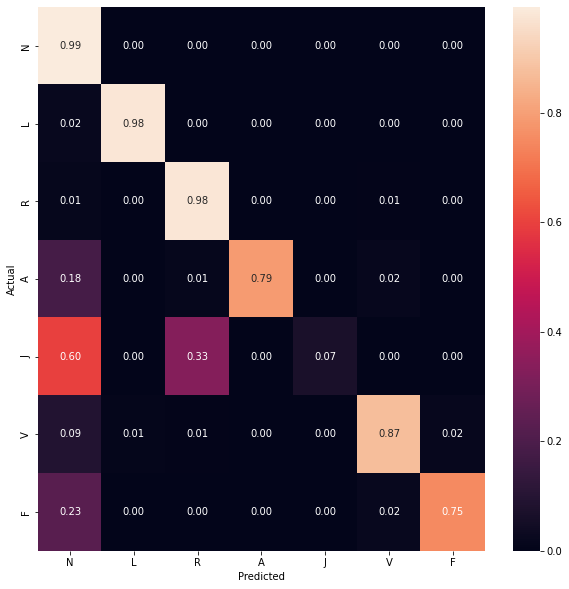

In [ ]:
#pred = model.predict(X_test)
matrix = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(pred, axis=-1))
target_names= basic_beats

#normalizing and plotting confussion matrix, taken from 
cmn = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


Above we have trained a model to distinguish between different tyopes of clinically relevant beats. For time purposes, I trained it on only 10000 beat samples of 2 seconds each. Performance can likely be improved if we use the entire dataset. Also, from looking at the confusion matrix we can see predictions are typically wrong for "J" beats, this is likely because not a lot of these beats are present in the training dataset, so some data augmentation  or using another dataset would be necessary to ensure the network learns to identify these types of beats.

We have to mske some very important remarks about this proof of concept:
 - Although this shows us that this architechture is useful for handling this type of data, the results are limited to the MIT dataset and might not work as well in the real world.

 - This network could not be approved for marketing because it has been trained on the MIT database. This database is used for validation of models, and thus a model needs to be trained with independant data to be able to validate it fully with MIT.

 - The network may be performing ell because it has been trained on individual channel beats. If the odel has seen a beat from channel A in training, and then it sees the same beat but in channel B in the test data, it will likely do very well on it because the beats must be somewhat similar. Ideally, the model should be trsined in beats that are not repeated across channels. 

 - This model assumes all given QRS are valid ECG data. Sometimes, whichever algorithm we use to identify Rpeaks will identify noise as Rpeaks. Thus, we must also have a trained noise model that can let us know if any of the beawts we are feeding to this model are likely noise so we can disregard or adjust the prediction.

 -The beats used to train and test this network are from a clinical study. Patients were lkikely at rest, which allows us to get a very clean signal.  In real life, the data might be very noisy if it's from a long-term wearable device like a holter or watch. Thus, the model must be trained on data that is equally noisy. 

## Activation study for the trained model

A big issue with deep learning models is interpretability. In these models, we apply a set of learned transformations to the data successively until we can connect it to a digested output. We can't always know what these transformations are or why they are learned. To shed some light on the interpretability of prediction, an activation study can be done. Activation studies can show, in a certain neural network layer, which features of the input are compelling the network to apply a certain transformation. By analysing the activation on the first layer, we can onserve which features of the ECG signal the different filters of the first layer are picking up. Typically it's some high-level feature such as patterns, edges and straight lines in the signal [9].

In [ ]:
map.shape

(720,)

 1/23 [>.............................] - ETA: 0s

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


23/23 [==============================] - 0s 1ms/step


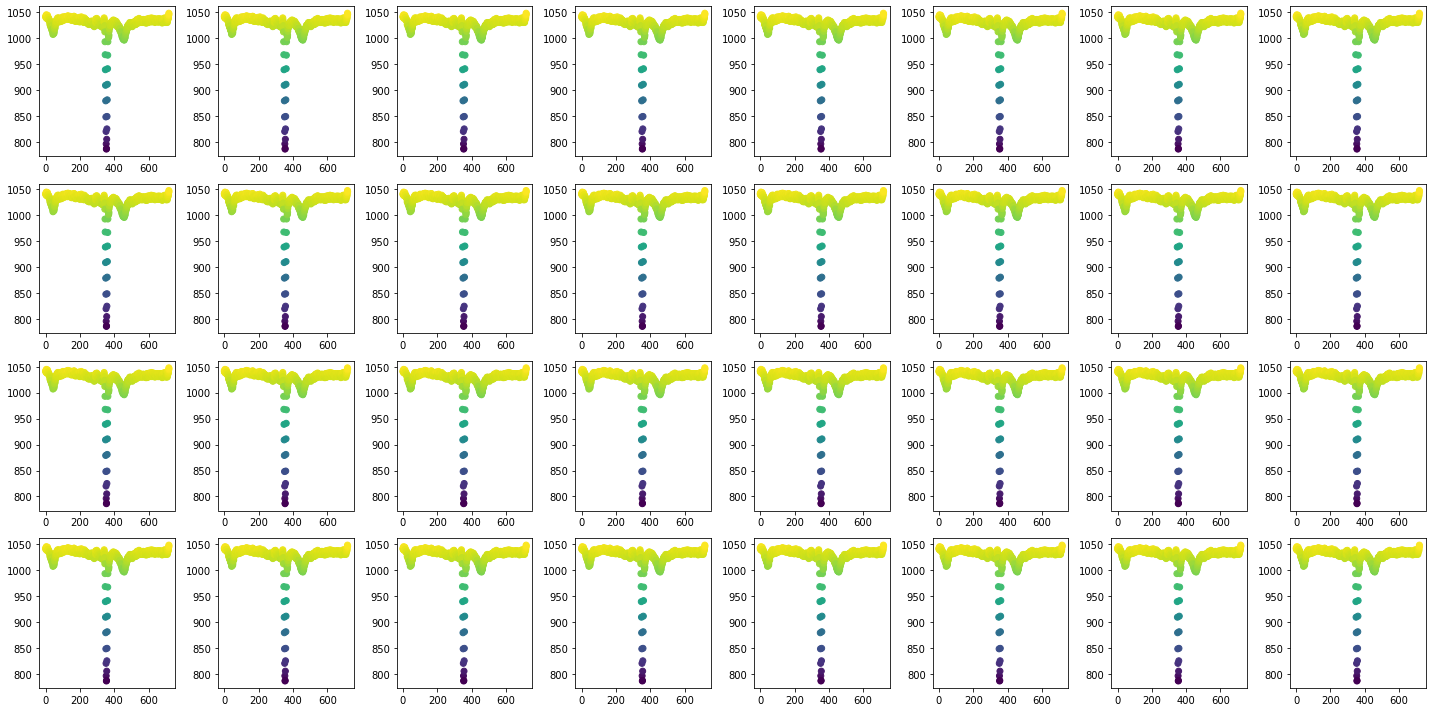

In [ ]:
#code to obtain activation of specified layer for a model
def get_feature_maps(model, layer_id, input):
    model_ = tf.keras.Model(inputs=[model.input], 
                   outputs=[model.layers[layer_id].output])
    return model_.predict(input[0:1])

#loading saved model, you can load from GitHub instead
model=tf.keras.models.load_model('/content/drive/MyDrive/QRS_beatdetector_720samples.hdf5', compile = False)

plt.figure(figsize=(20,10))

for i in range(32):
    #generate map for every filter of first layer
    map=get_feature_maps(model, 0, X_test[0])
    plt.subplot(4, 8, i+1)
    #plotting data and coloring it according to saliency to each filter
    plt.scatter( range(len(X_test[0])),X_test[0].flatten(), c=map[:,:,i ])
plt.tight_layout()  